# 1. Data Exploration

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
start_time = time.time()

In [3]:
df = pd.read_csv('C:/Users/vvaib/OneDrive/Desktop/McGill MMA/MMA 2021/WInter semester/INSY_695/on_cloud_wine/winemag-data-130k-v2.csv',index_col=0)

## 1.1 Drop Duplicates

In [4]:
df[df.duplicated('description',keep=False)].sort_values('description').head(5)

country                                        description  \
67614       US  100% Malbec, it's redolent with dark plums, wi...   
46540       US  100% Malbec, it's redolent with dark plums, wi...   
119702      US  100% Sangiovese, this pale pink wine has notes...   
72181       US  100% Sangiovese, this pale pink wine has notes...   
73731   France  87-89 Barrel sample. A pleasurable, perfumed w...   

          designation  points  price    province              region_1  \
67614             NaN      87   20.0  Washington     Rattlesnake Hills   
46540             NaN      87   20.0  Washington     Rattlesnake Hills   
119702         Meadow      88   18.0  Washington  Columbia Valley (WA)   
72181          Meadow      88   18.0  Washington  Columbia Valley (WA)   
73731   Barrel sample      88    NaN    Bordeaux          Saint-Julien   

               region_2       taster_name taster_twitter_handle  \
67614   Columbia Valley  Sean P. Sullivan         @wawinereport   
46540   Columbia Valley  Sean P. Sullivan         @wawinereport   
119702  Columbia Valley  Sean P. Sullivan         @wawinereport   
72181   Columbia Valley  Sean P. Sullivan         @wawinereport   
73731               NaN        Roger Voss            @vossroger   

                                                    title  \
67614          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
46540          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
119702  Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
72181   Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
73731   Château Lalande-Borie 2008 Barrel sample  (Sai...   

                         variety                 winery  
67614                     Malbec             Roza Ridge  
46540                     Malbec             Roza Ridge  
119702                      Rosé            Ross Andrew  
72181                       Rosé            Ross Andrew  
73731   Bordeaux-style Red Blend  Château Lalande-Borie

We realized some records/descriptions are duplicated, so we remvoe those entries that are duplicated.

In [5]:
df = df.drop_duplicates('description')

df.shape

(119955, 13)

In [6]:
from pandas_profiling import ProfileReport
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')

## 1.2 Check missing values

In [7]:
def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [8]:
# Missing values statistics
miss_values = missing_values(df)
miss_values.head(20)

Dataframe has 13 columns.
There are 9 columns that have missing values.


Missing Values  % of Total Values
region_2                        73195               61.0
designation                     34532               28.8
taster_twitter_handle           29441               24.5
taster_name                     24912               20.8
region_1                        19558               16.3
price                            8388                7.0
country                            59                0.0
province                           59                0.0
variety                             1                0.0

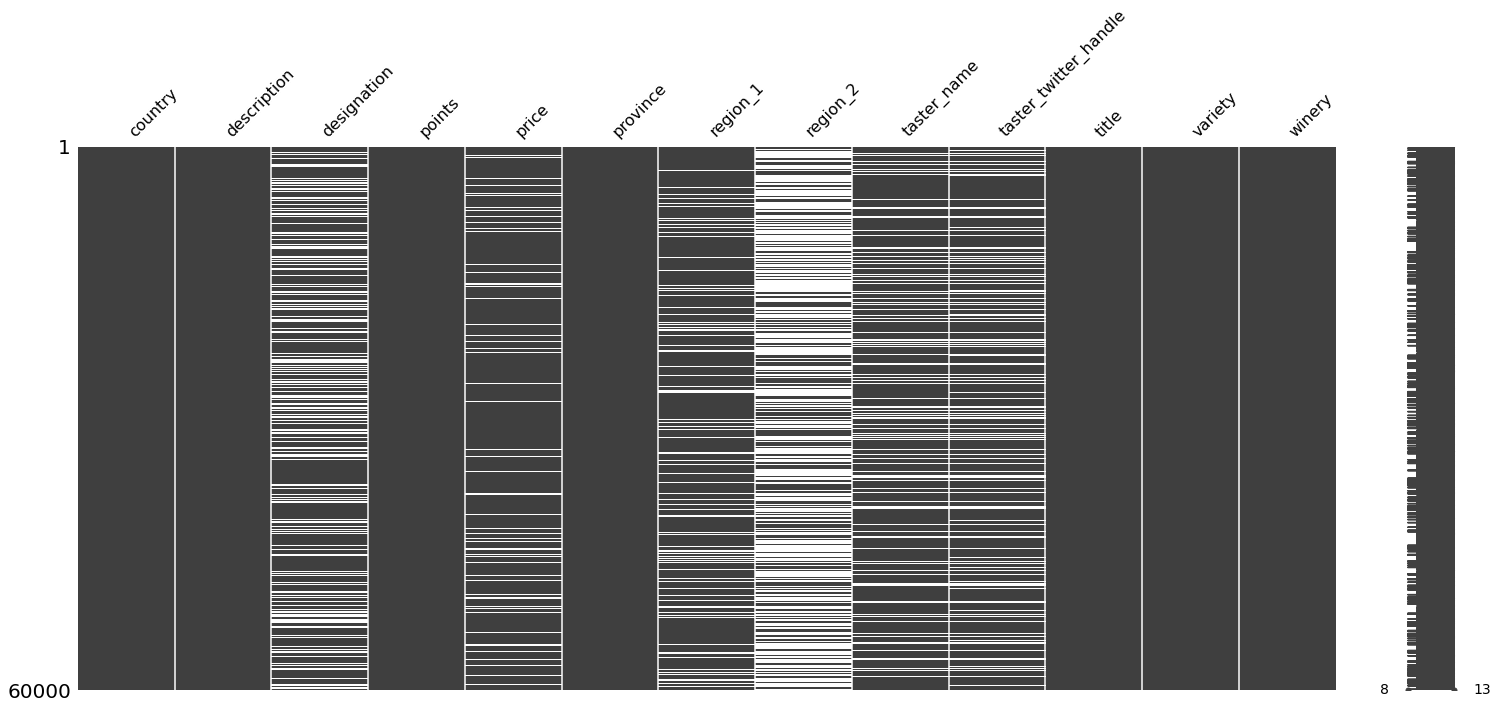

In [9]:
import missingno as msno
%matplotlib inline
ax = msno.matrix(df.sample(60000))

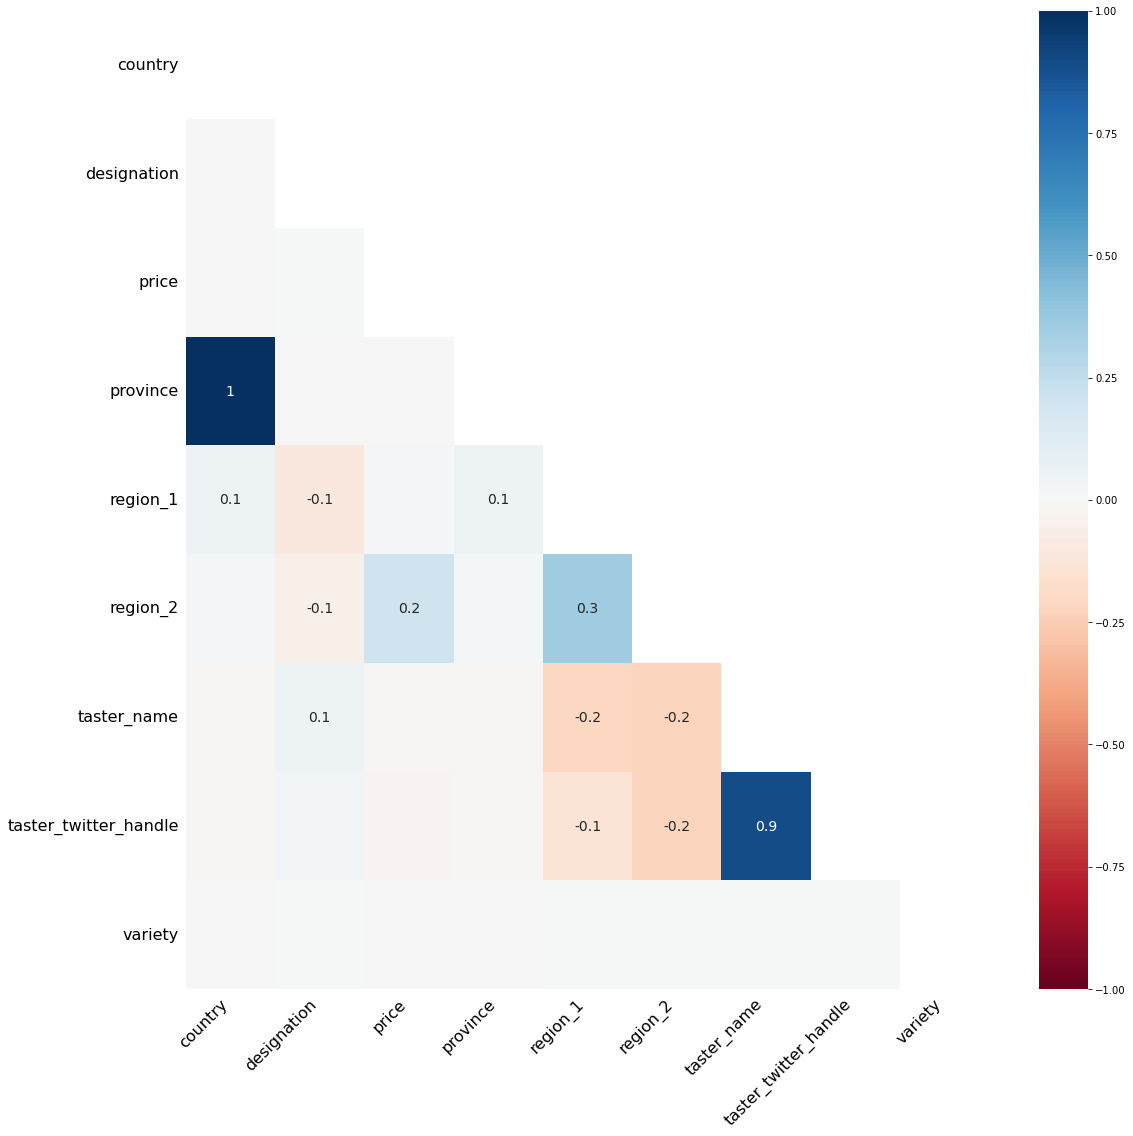

In [10]:
ax = msno.heatmap(df, figsize=(18, 18))

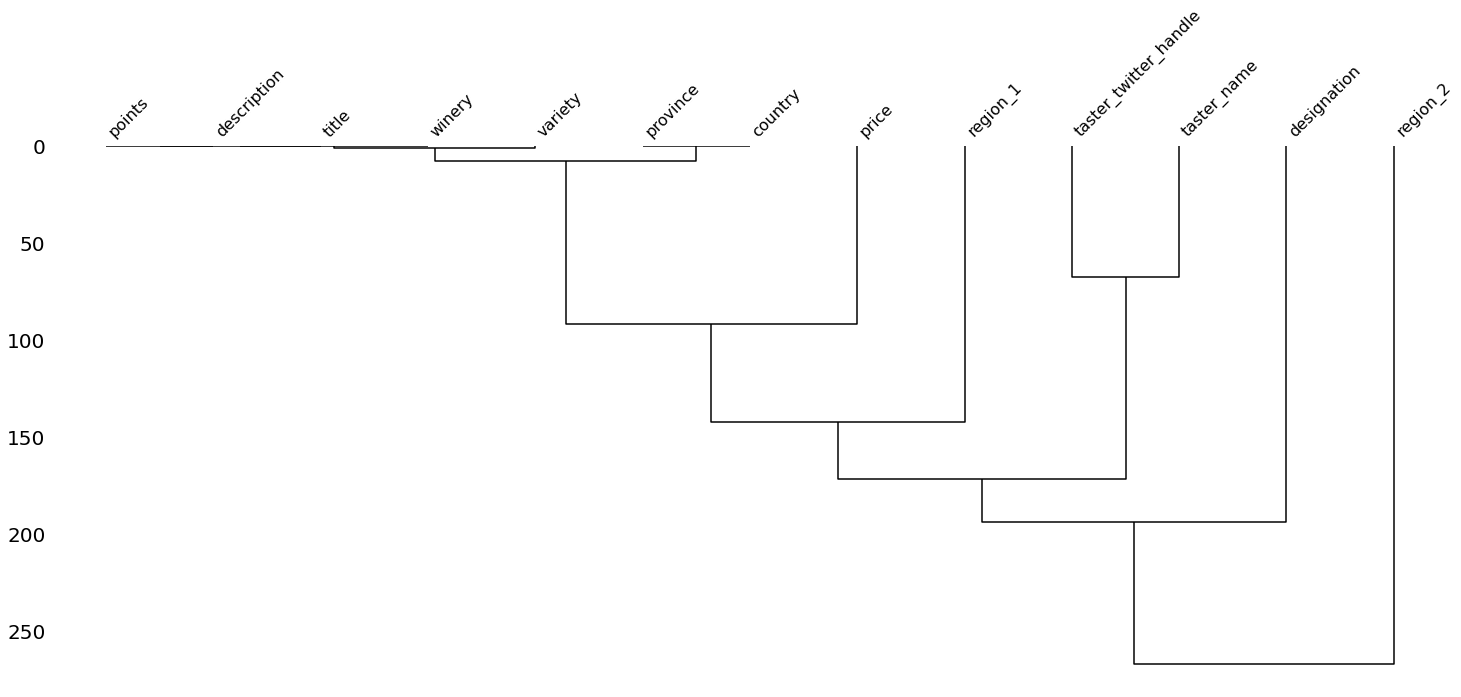

In [11]:
ax = msno.dendrogram(df)

## 1.3 Explore Target Variable

### 1.3.1 Drop rows with missing target

In [12]:
df.price.isna().sum()

8388

Around 8k obs have missing price, so we drop them

In [13]:
df = df.dropna(subset=['price'])

In [14]:
len(df['price'].unique())

390

### 1.3.2 Check distribution of target var

<AxesSubplot:xlabel='price', ylabel='Count'>

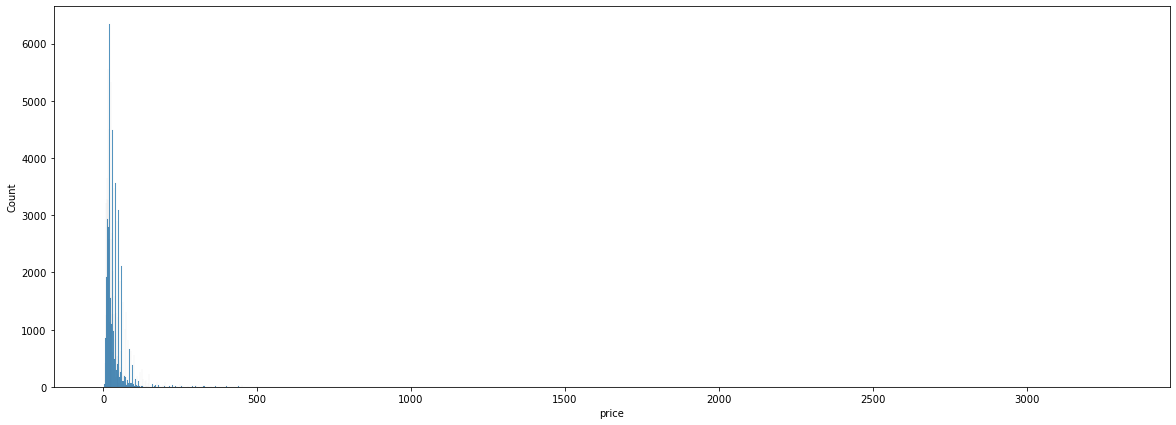

In [15]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='price',data=df)

The distrbution is very skewed

<AxesSubplot:xlabel='price', ylabel='Count'>

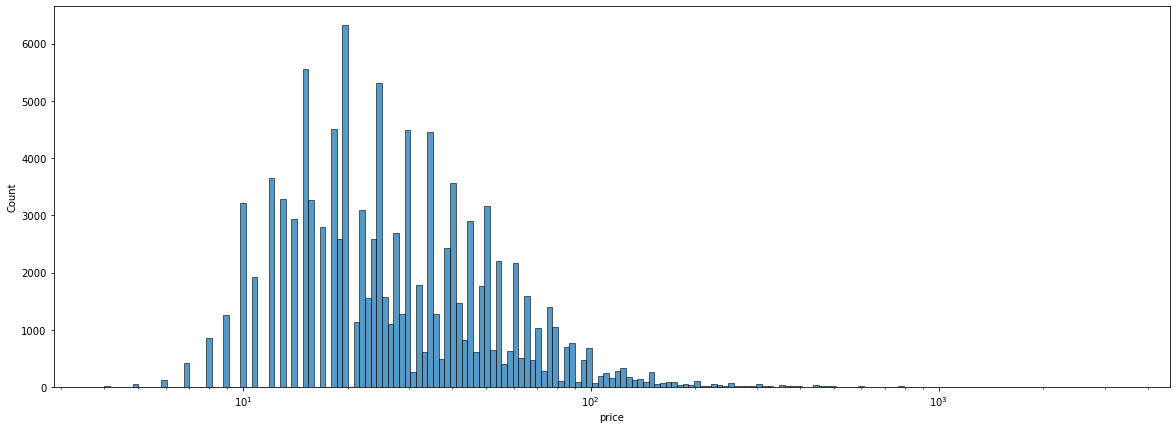

In [16]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='price',data=df,log_scale=True)

After log-transforming the distribution, we find this is more normal, but still skewed to the right due to those very  expensive wines

Most of the prices are below 200. So we zoom in to see the distribution of those which have price less than 200

<AxesSubplot:xlabel='price', ylabel='Count'>

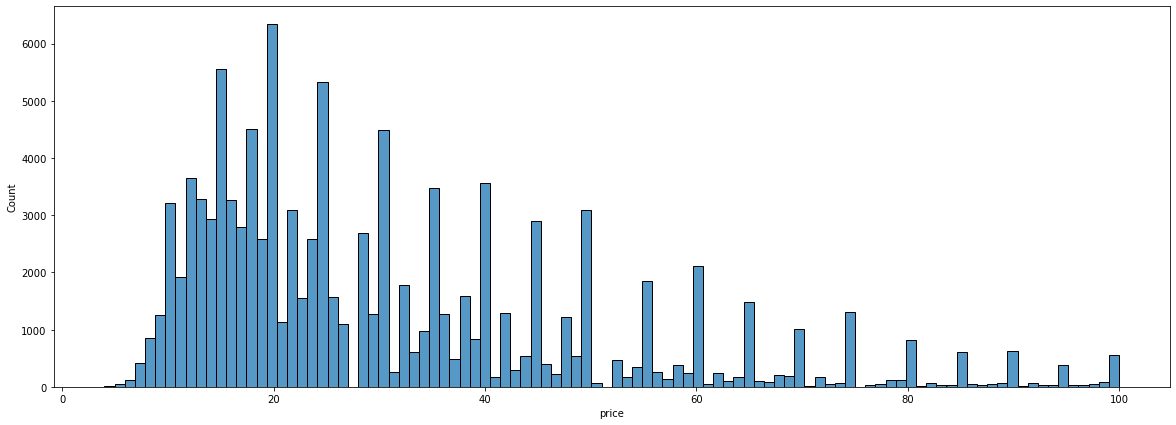

In [17]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='price',data=df[df.price<=100])

This is still very skewed. And About 97% of all wines have price less than 100. 

In [18]:
len(df[df.price<=100])/len(df) 

0.9710577500515385

## 1.4 Explore 'Country'

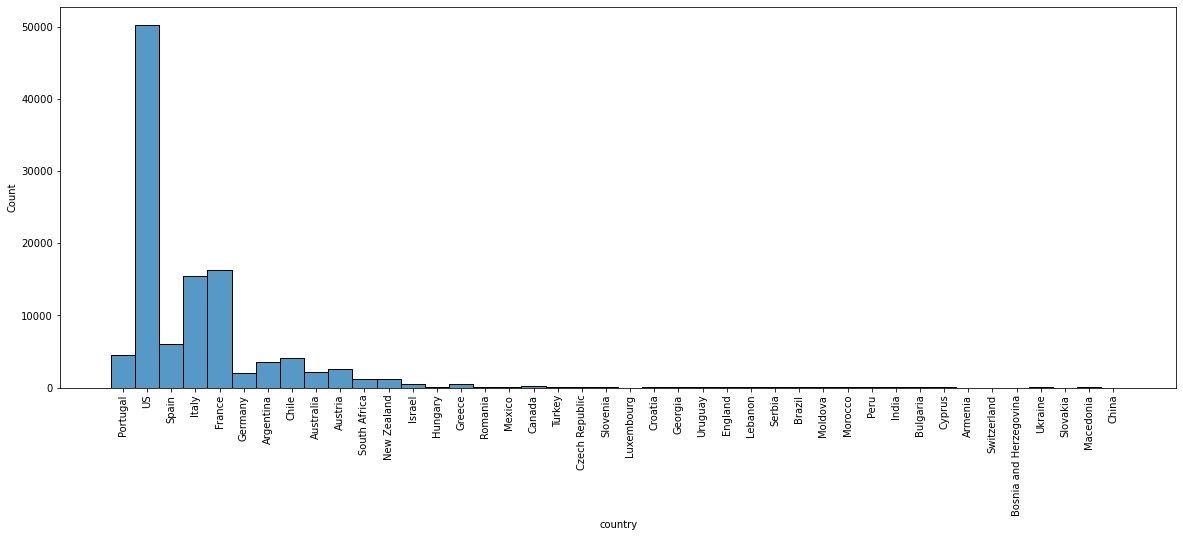

In [19]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='country',data=df)
plt.xticks(rotation = 90)
plt.show()

In [20]:
country = df.groupby('country').size().reset_index(name='count').sort_values('count', ascending=False)
px.bar(country.head(10), x='country', y='count', template='simple_white')

In [21]:
px.choropleth(country, locations = 'country', locationmode='country names', color = 'count', 
              template = 'simple_white',range_color=[2000,15000], color_continuous_scale='Viridis')

### 1.4.1 Compare against target

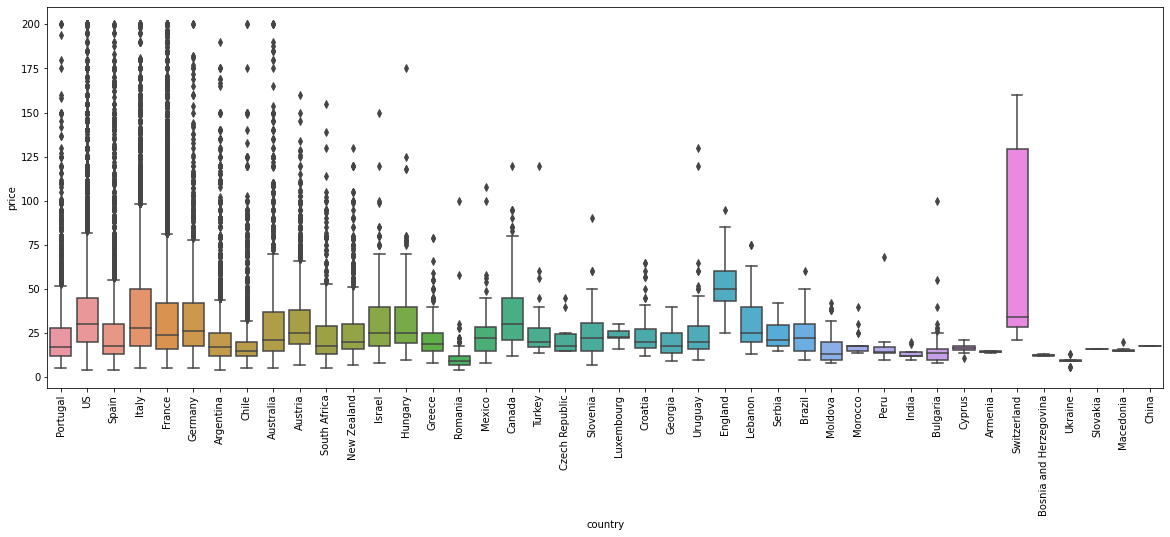

In [22]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='price', data=df[df.price<=200], ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [23]:
df.country.isna().sum()

55

In [24]:
df.province.isna().sum()

55

Look for Na in the data. As we can see country and province have the same number of missing values. During the data exploration, it was determined that we would fill the empty country data with data from province or region, and vice versa. This wasn't possible as they were both missing for all these instances. So the missing values (only 59) were dropped. Price is the target variables so missing price rows were also dropped. Designation was also dropped as it was determined to be useless.

In [25]:
df = df.dropna(subset=['country'], inplace=False)
df = df.dropna(subset=['province'], inplace=False)

In [26]:
df.shape

(111512, 13)

## 1.5 Explore 'Designation'

In [27]:
df.designation.value_counts()

Reserve                             1844
Estate                              1217
Reserva                             1138
Estate Grown                         565
Riserva                              560
                                    ... 
Thomas T Thomas Vineyard Reserve       1
The Duke                               1
Lillian Vineyard Estate Grown          1
Viña Salort Reserva                    1
Lieu-dit Harth Cuvée Caroline          1
Name: designation, Length: 35749, dtype: int64

Desgination is too diverse with 35749 dintinct values and the most frequent one Reserve has has 1844 records out of 100k observations. So we drop this column

In [28]:
df = df.drop(columns=['designation'])

## 1.6 Explore 'Designation'

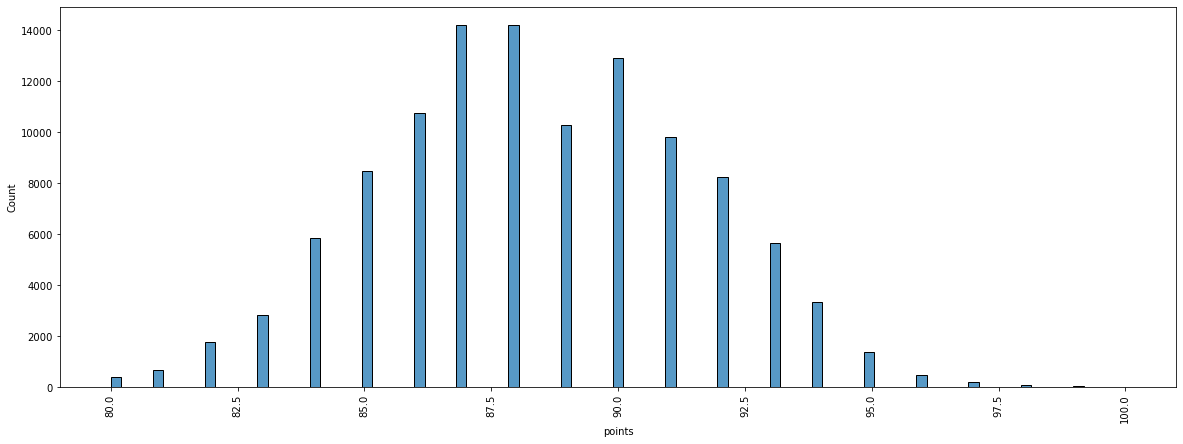

In [29]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='points',data=df)
plt.xticks(rotation = 90)
plt.show()

## 1.7 Explore 'Region 2'

In [30]:
df.region_2.isna().sum()/len(df)

0.5824754286534185

In [31]:
df.region_2.value_counts()

Central Coast        10149
Sonoma                8372
Columbia Valley       7421
Napa                  6359
Willamette Valley     3135
California Other      2497
Finger Lakes          1633
Sierra Foothills      1344
Napa-Sonoma           1083
Central Valley         988
Southern Oregon        837
Oregon Other           669
Long Island            605
North Coast            533
Washington Other       488
South Coast            241
New York Other         205
Name: region_2, dtype: int64

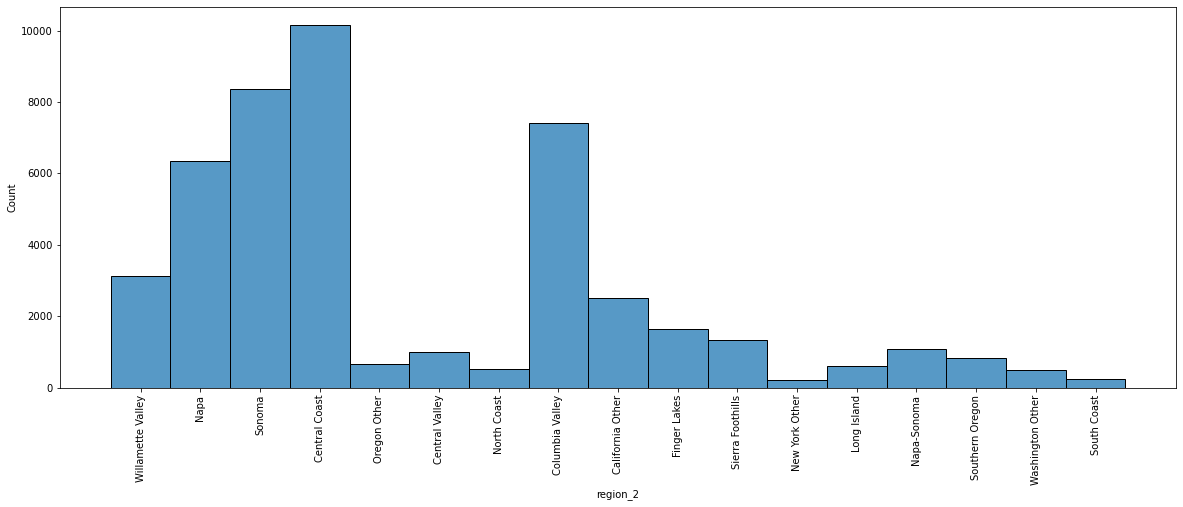

In [32]:
fig, ax = plt.subplots(figsize = (20,7))
sns.histplot(x='region_2',data=df)
plt.xticks(rotation = 90)
plt.show()

### 1.7.1 Compare against target

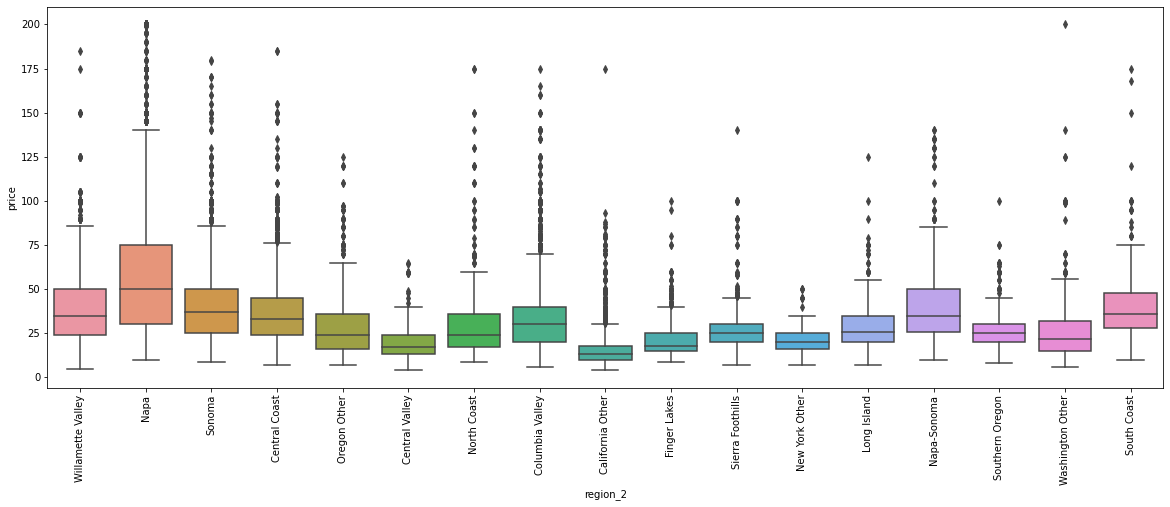

In [33]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='region_2',y='price', data=df[df.price<=200], ax = ax)
plt.xticks(rotation = 90)
plt.show()

From the price vs region_2 bar plot, we can see there is not much difference among the distrbutions, the medians for all region 2 are roughly between 25 and 50. And since 60% of region 2 is missing, which represent roughlt half of the dataset, it is maybe the case that the missingness is not at random. So we decide to add an indicator to missing region 2 rows.

## 1.8 Explore 'Taster Name'

In [34]:
df.taster_name.value_counts()

Roger Voss            18543
Michael Schachner     13863
Kerin O’Keefe          8872
Paul Gregutt           8836
Virginie Boone         8681
Matt Kettmann          5642
Joe Czerwinski         4642
Sean P. Sullivan       4422
Anna Lee C. Iijima     3974
Jim Gordon             3761
Anne Krebiehl MW       3027
Lauren Buzzeo          1581
Susan Kostrzewa        1005
Mike DeSimone           441
Jeff Jenssen            415
Alexander Peartree      381
Carrie Dykes            128
Fiona Adams              24
Christina Pickard         6
Name: taster_name, dtype: int64

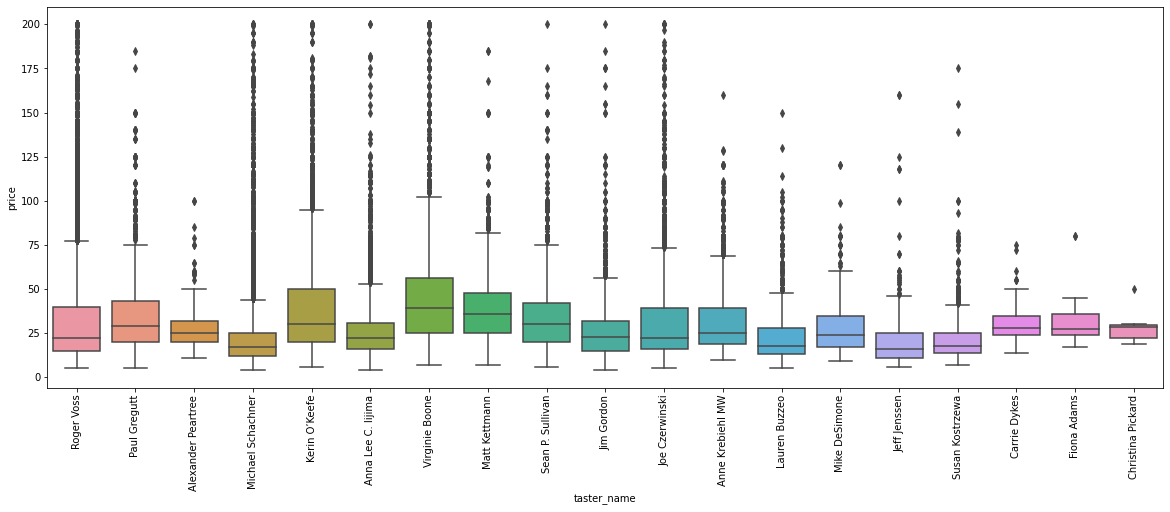

In [35]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='taster_name',y='price', data=df[df.price<=200], ax = ax)
plt.xticks(rotation = 90)
plt.show()

For tasters, we dummy-encode top 5 tasters and group the other tasters as others.

In [36]:
from sklearn.preprocessing import OneHotEncoder

## 1.9 Explore 'Title'

### 1.9.1 Generate Wordcloud

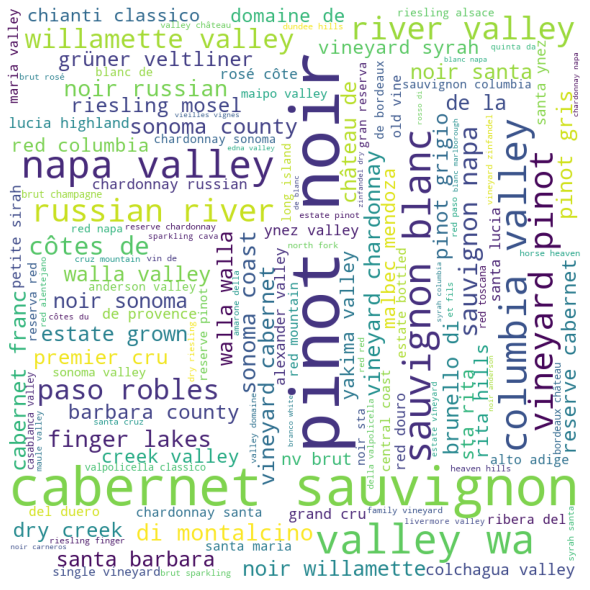

In [37]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.title:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',prefer_horizontal=0.5,
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### 1.9.2 Extract year from title

In [38]:
def get_year(title):
    year_of_wine=title.str.extract('(\d{4})').astype('float')
    year_of_wine = year_of_wine.replace({tuple(np.arange(0,1900)):np.nan,tuple(np.arange(2020,8000)):np.nan})
    return year_of_wine

In [39]:
year = get_year(df.title)
year.columns = ['year']
year.isna().sum()

year    3964
dtype: int64

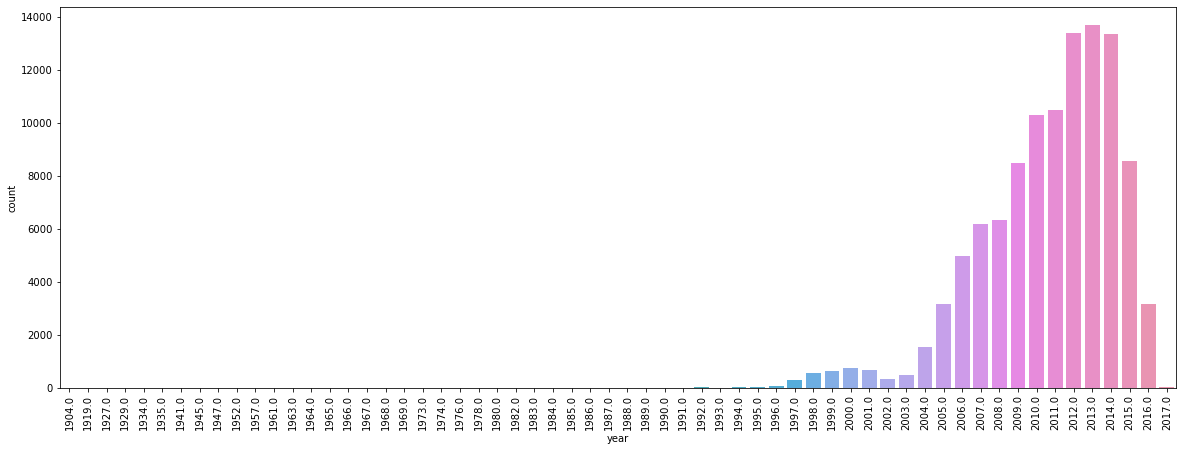

In [40]:
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='year', data=year, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

## 1.10 Explore 'Variety'

Here we create a histogram for top varieties that have more than 200 reviews

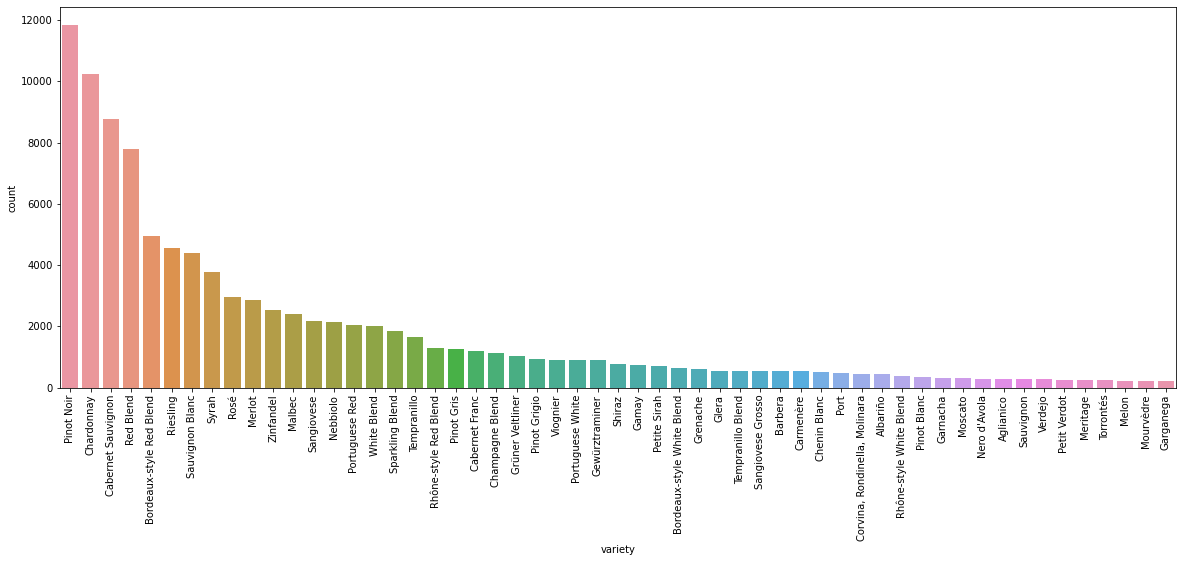

In [41]:
top_variety = df.groupby('variety').filter(lambda x: len(x) >200)
count_list = top_variety.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=top_variety, order = count_list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

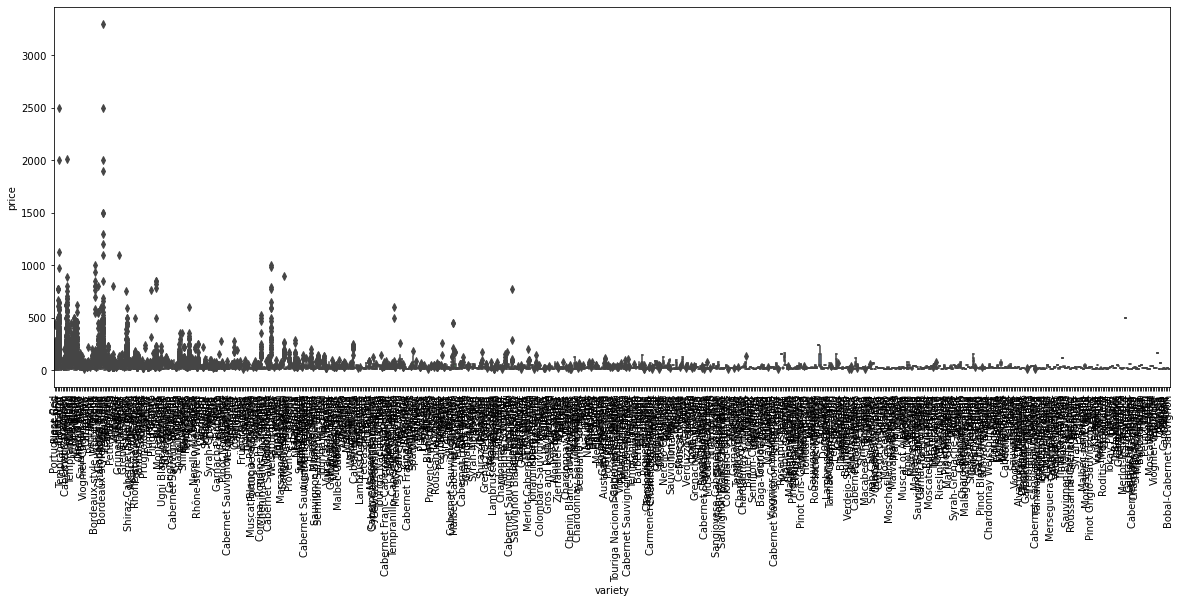

In [42]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='price', data=df, ax = ax)
plt.xticks(rotation = 90)
plt.show()

# 2. Description field

## 2.1 Generate Wordcloud

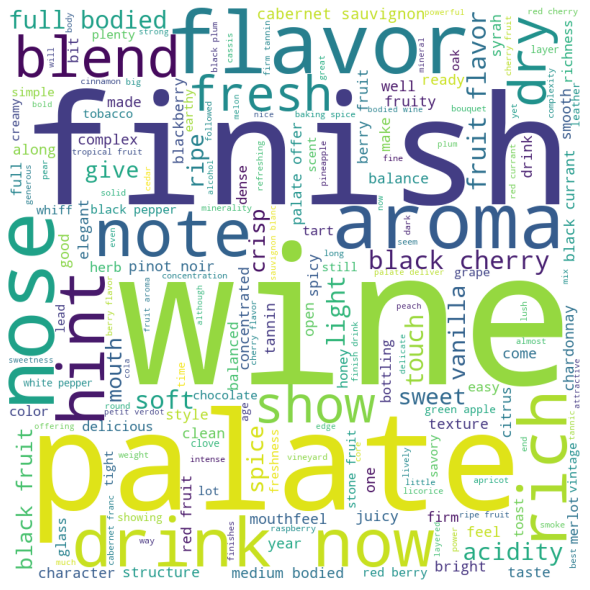

In [43]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.description:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',prefer_horizontal=0.5,
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## 2.2 Profiling Report

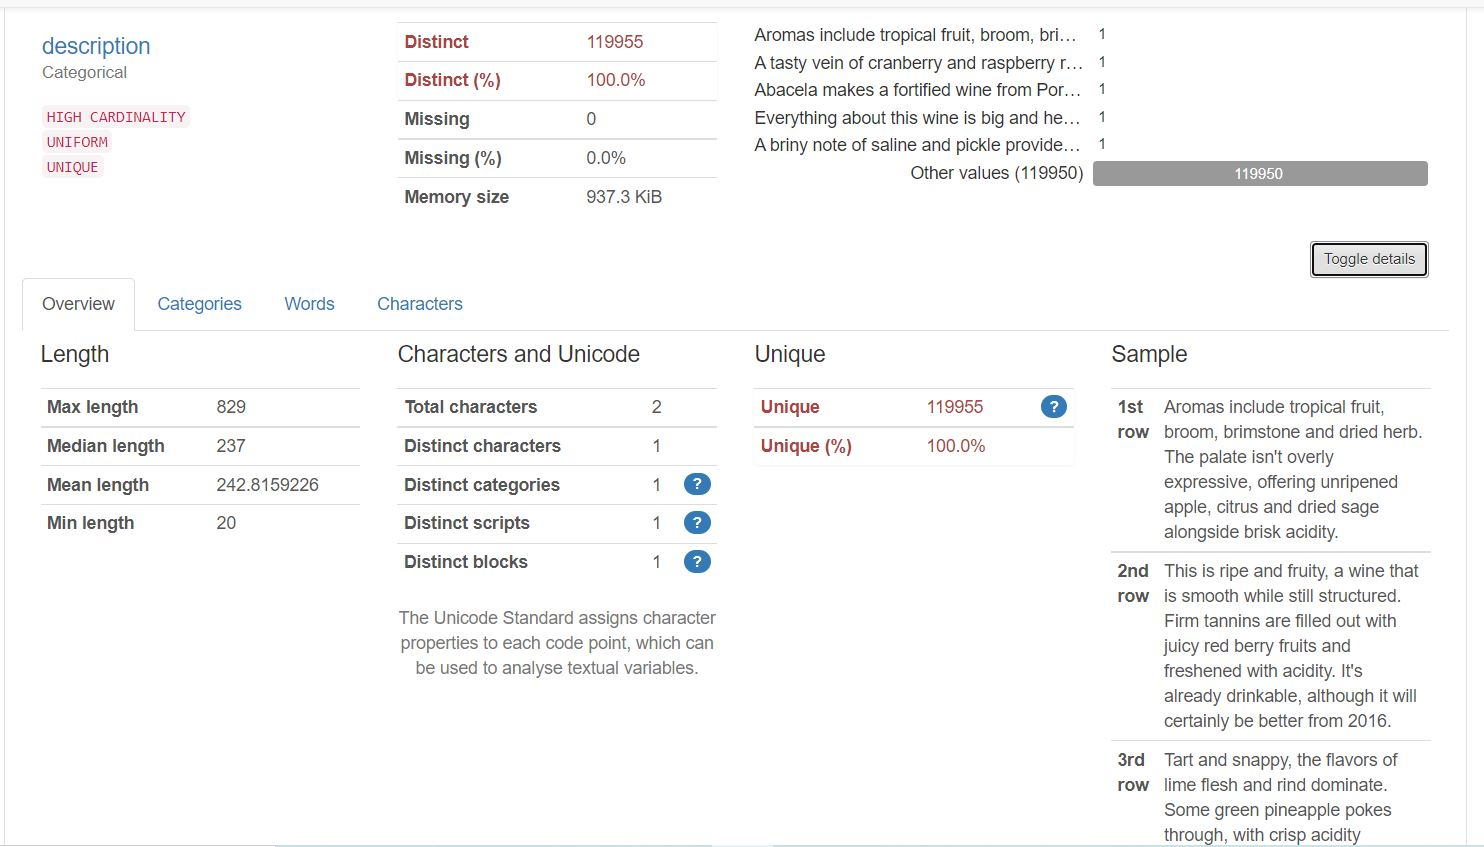

The description column has 100% unique values and the column describes the wine's texture, aroma, composition, complexity etc. This is crucial for our analysis, so we have decided to analyse the column and seggregate the decription into several columns based on the description text. The base reference is chosen using the following wine wheel descriptors.

## 2.3 Wine Aroma Wheel Descriptor

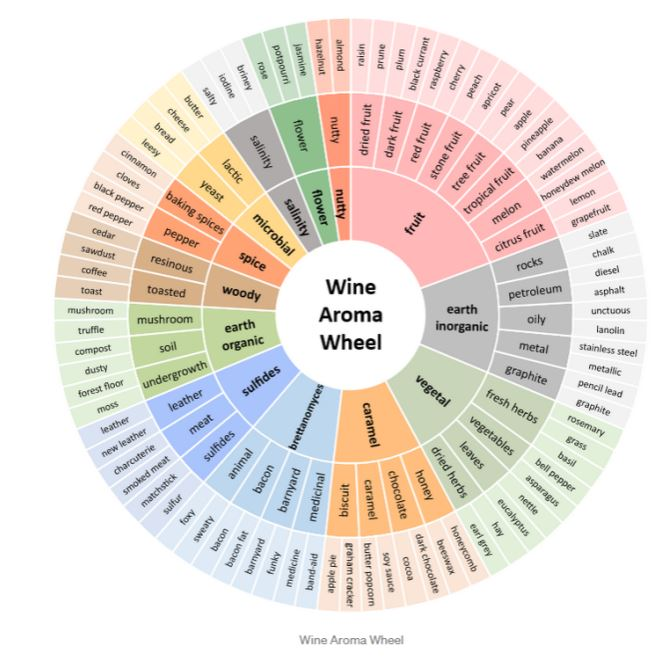

In [44]:
Wine_Aroma_Wheel =['almond', 'animal', 'apple', 'apple pie', 'apricot', 'asparagus',
       'asphalt', 'bacon', 'bacon fat', 'baking spices', 'banana',
       'band-aid', 'barnyard', 'basil', 'beeswax', 'bell pepper',
       'biscuit', 'black currant', 'black pepper', 'bread', 'briney',
       'butter', 'butter popcorn', 'caramel', 'cedar', 'chalk',
       'charcuterie', 'cheese', 'cherry', 'chocolate', 'cinnamon',
       'citrus fruit', 'cloves', 'cocoa', 'coffee', 'compost',
       'dark chocolate', 'dark fruit', 'diesel', 'dried fruit',
       'dried herbs', 'dusty', 'earl grey', 'eucalyptus', 'flower',
       'forest floor', 'foxy', 'fresh herbs', 'fruit', 'funky',
       'graham cracker', 'grapefruit', 'graphite', 'grass', 'hay',
       'hazelnut', 'herb', 'honey', 'honeycomb', 'honeydew melon',
       'iodine', 'jasmine', 'lactic', 'lanolin', 'leather', 'leaves',
       'leesy', 'lemon', 'matchstick', 'meat', 'medicinal', 'medicine',
       'melon', 'metal', 'metallic', 'moss', 'mushroom', 'nettle',
       'new leather', 'nutty', 'oily', 'peach', 'pear', 'pencil lead',
       'pepper', 'petroleum', 'pineapple', 'plum', 'potpourri', 'prune',
       'raisin', 'raspberry', 'red fruit', 'red pepper', 'resinous',
       'rocks', 'rose', 'rosemary', 'salinity', 'salty', 'sawdust',
       'slate', 'smoked meat', 'soil', 'soy sauce', 'stainless steel',
       'stone fruit', 'sulfides', 'sulfur', 'sweaty', 'toast', 'toasted',
       'tree fruit', 'tropical fruit', 'truffle', 'unctuous',
       'undergrowth', 'vegetables', 'watermelon', 'yeat']

## 2.4 Wine Non Aroma Wheel Descriptor

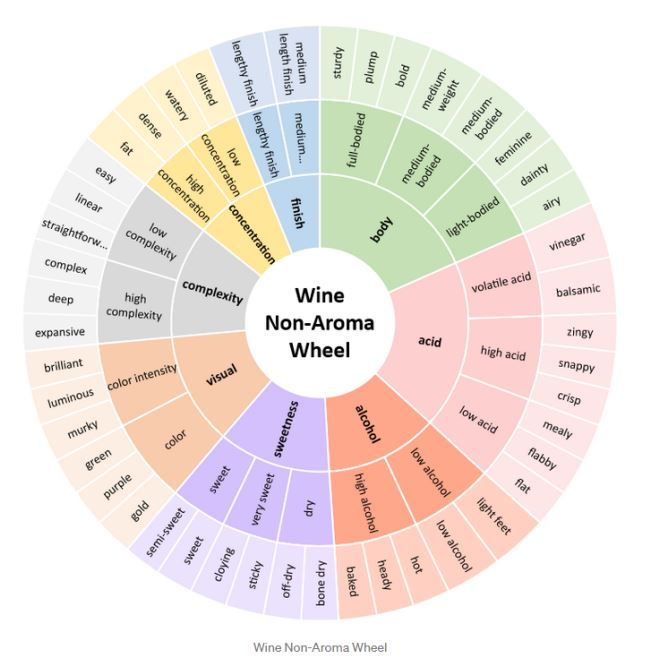

In [45]:
Wine_Non_Aroma_Wheel =['airy', 'baked', 'balsamic', 'bold', 'bone dry', 'brilliant',
       'cloying', 'color', 'color intensity', 'complex', 'crisp',
       'dainty', 'deep', 'dense', 'diluted', 'dry', 'easy', 'expansive',
       'fat', 'feminine', 'flabby', 'flat', 'full-bodied', 'gold',
       'green', 'heady', 'high acid', 'high alcohol', 'high complexity',
       'high concentration', 'hot', 'lengthy finish', 'light fleet',
       'light-bodied', 'linear', 'low acid', 'low alcohol',
       'low complexity', 'low concentration', 'luminous', 'mealy',
       'medium', 'medium length finish', 'medium-bodied', 'murky',
       'off-dry', 'plump', 'purple', 'semi-sweet', 'snappy', 'sticky',
       'straightforward', 'sturdy', 'sweet', 'very sweet', 'vinegar',
       'volatile acid', 'watery', 'zingy']

## 2.5 Remove stopwords from description and calculate frequency of words from wine wheels.

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vvaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vvaib\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vvaib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
# Create columns for the Wine Aroma descriptions
for W in Wine_Aroma_Wheel:
    df[W]=0

# Create columns for the Wine Non-Aroma descriptions
for W in Wine_Non_Aroma_Wheel:
    df[W]=0
    
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# check if the wine aroma/ wine non aroma word is present in the description. Add frequency to the corresponding column.
for j in range(len(df['description'])):
    for i in range(len(Wine_Aroma_Wheel)):
        if Wine_Aroma_Wheel[i] in df['description'].iloc[j].lower():
            df[Wine_Aroma_Wheel[i]].iat[j] =df[Wine_Aroma_Wheel[i]].iloc[j]+1
    for i1 in range(len(Wine_Non_Aroma_Wheel)):
        if Wine_Non_Aroma_Wheel[i1] in df['description'].iloc[j].lower():
            df[Wine_Non_Aroma_Wheel[i1]].iat[j] =df[Wine_Non_Aroma_Wheel[i1]].iloc[j]+1

C:\Users\vvaib\AppData\Local\Temp/ipykernel_13436/1890950539.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\vvaib\AppData\Local\Temp/ipykernel_13436/1890950539.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



# 3. Further Preprocessing

In [48]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [49]:
df.columns[0:20]

Index(['country', 'description', 'points', 'price', 'province', 'region_1',
       'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety',
       'winery', 'almond', 'animal', 'apple', 'apple pie', 'apricot',
       'asparagus', 'asphalt', 'bacon'],
      dtype='object')

In [50]:
df.columns

Index(['country', 'description', 'points', 'price', 'province', 'region_1',
       'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       ...
       'snappy', 'sticky', 'straightforward', 'sturdy', 'sweet', 'very sweet',
       'vinegar', 'volatile acid', 'watery', 'zingy'],
      dtype='object', length=191)

## 3.1 Split train/test to avoid information leakage

In [51]:
#X = df[['country', 'description', 'designation', 'points', 'province',
#       'region_1', 'region_2', 'taster_name', 'title','variety']]
X = df.drop(['description','price', 'taster_twitter_handle','winery'],axis=1)

In [52]:
y= df[['price']]

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [55]:
X_train

country  points      province                             region_1  \
129187   Spain      84       Levante                             Valencia   
26755    Italy      90      Piedmont                               Barolo   
104470      US      93    California                          Paso Robles   
70460       US      92    California                      Howell Mountain   
61832    Italy      89        Veneto  Amarone della Valpolicella Classico   
...        ...     ...           ...                                  ...   
23183   France      93  Rhône Valley                             Condrieu   
50866       US      82    California                     Alexander Valley   
47204       US      82    California                        Amador County   
48274       US      92    California                 Russian River Valley   
77308    Italy      90      Piedmont                               Barolo   

                region_2        taster_name  \
129187               NaN  Michael Schachner   
26755                NaN      Kerin O’Keefe   
104470     Central Coast      Matt Kettmann   
70460               Napa     Virginie Boone   
61832                NaN                NaN   
...                  ...                ...   
23183                NaN     Joe Czerwinski   
50866             Sonoma                NaN   
47204   Sierra Foothills                NaN   
48274             Sonoma                NaN   
77308                NaN                NaN   

                                                    title  \
129187  Pluvium 2015 Premium Selection Bobal-Cabernet ...   
26755               Sobrero 2012 Ciabot Tanasio  (Barolo)   
104470                Shale Oak 2012 Ku Red (Paso Robles)   
70460   Pine Ridge 2012 Cabernet Sauvignon (Howell Mou...   
61832   Villa Spinosa 2004  Amarone della Valpolicella...   
...                                                   ...   
23183   Michel & Stéphane Ogier 2011 La Combe de Malle...   
50866    H & G 2010 Cabernet Sauvignon (Alexander Valley)   
47204   Sobon Estate 2006 Rezerve Primitivo (Amador Co...   
48274   Williams Selyem 2005 Allen Vineyard Chardonnay...   
77308                                Parusso 2008  Barolo   

                              variety  almond  animal  ...  snappy  sticky  \
129187       Bobal-Cabernet Sauvignon       0       0  ...       0       0   
26755                        Nebbiolo       0       0  ...       0       0   
104470                      Red Blend       0       0  ...       0       0   
70460              Cabernet Sauvignon       0       0  ...       0       0   
61832   Corvina, Rondinella, Molinara       0       0  ...       0       0   
...                               ...     ...     ...  ...     ...     ...   
23183         Rhône-style White Blend       0       0  ...       0       0   
50866              Cabernet Sauvignon       0       0  ...       0       0   
47204                       Primitivo       0       0  ...       0       0   
48274                      Chardonnay       0       0  ...       0       0   
77308                        Nebbiolo       0       0  ...       0       0   

        straightforward  sturdy  sweet  very sweet  vinegar  volatile acid  \
129187                0       0      0           0        0              0   
26755                 0       0      0           0        0              0   
104470                0       0      0           0        0              0   
70460                 0       0      0           0        0              0   
61832                 0       0      0           0        0              0   
...                 ...     ...    ...         ...      ...            ...   
23183                 0       0      0           0        0              0   
50866                 0       0      0           0        0              0   
47204                 0       0      0           0        0              0   
48274                 0       0      0           0        0        

In [56]:
# country	province	region_1	region_2	taster_name	title	variety

## 3.2 Country Preprocessing: Select Top 10 Categories and Group others as Other

In [60]:
def group_country(country):
    countries = 10
    country_to_keep = country.value_counts(dropna=False)[:countries].index
    country_list = []
    for i in country:
        if i in country_to_keep:
            country_list.append(i)
        else:
            country_list.append('Other')
    return np.array(country_list).reshape((-1,1))

In [61]:
country_grouping = FunctionTransformer(func = group_country)
ohe_country = OneHotEncoder(handle_unknown='ignore')
country_grouping_pipe = make_pipeline(country_grouping,ohe_country)

## 3.3 Province Preprocessing: Select Top 20 Categories and Group others as Other

In [62]:
def group_province(province):
    provinces = 20
    province_to_keep = province.value_counts(dropna=False)[:provinces].index
    province_list = []
    for i in province:
        if i in province_to_keep:
            province_list.append(i)
        else:
            province_list.append('Other')
    return np.array(province_list).reshape((-1,1))

In [63]:
province_grouping = FunctionTransformer(func = group_province)
ohe_province = OneHotEncoder(handle_unknown='ignore')
province_grouping_pipe = make_pipeline(province_grouping,ohe_province)

## 3.4 Region 1 Preprocessing: Select Top 20 Categories and Group others as Other

In [64]:
def group_region_1(region_1):
    region_1s = 20
    region_1_to_keep = region_1.value_counts(dropna=False)[:region_1s].index
    region_1_list = []
    for i in region_1:
        if i in region_1_to_keep:
            region_1_list.append(i)
        else:
            region_1_list.append('Other')
    return np.array(region_1_list).reshape((-1,1))

In [65]:
region_1_grouping = FunctionTransformer(func = group_region_1)
ohe_region_1 = OneHotEncoder(handle_unknown='ignore')
region_1_grouping_pipe = make_pipeline(region_1_grouping,ohe_region_1)

## 3.5 Region_2 Preprocesing: Add indicator for missing values

In [66]:
def missing_indicator_region_2(region_2):
    X = pd.DataFrame()
    X['missing_region_2'] = np.where(region_2.isnull(), 1, 0)
    return X

In [67]:
region_2_missing = FunctionTransformer(func=missing_indicator_region_2)


## 3.6 Taster Preprocesing: Select top 5 tasters and group others as 'Other'

In [68]:
def group_taster(taster_name):
    tasters = 5
    tasters_to_keep = taster_name.value_counts(dropna=False)[:tasters].index
    taster_list = []
    for i in taster_name:
        if i in tasters_to_keep:
            taster_list.append(i)
        else:
            taster_list.append('Other')
    return np.array(taster_list).reshape((-1,1))
#     X = pd.DataFrame()
#     X["taster_Roger_Voss"] = np.where(taster_name=='Roger Voss', 1, 0)
#     X["taster_Michael_Schachner"] = np.where(taster_name=='Michael Schachner', 1, 0)
#     X["taster_Paul_Gregutt"] = np.where(taster_name=='Paul Gregutt', 1, 0)
#     X["taster_Virginie_Boone"] = np.where(taster_name=='Virginie Boone', 1, 0)
#     X["taster_Kerin_O’Keefe"] = np.where(taster_name=="Kerin O’Keefe", 1, 0)
#     X["taster_Other_tasters"] = np.where((taster_name!='Roger Voss')&
#                                     (taster_name!='Michael Schachner')&
#                                     (taster_name!='Paul Gregutt')&
#                                     (taster_name!='Virginie Boone')&
#                                     (taster_name!="Kerin O’Keefe"), 1, 0)
#    return X

In [69]:
taster_grouping = FunctionTransformer(func=group_taster)
ohe_taster = OneHotEncoder(handle_unknown='ignore')
taster_grouping_pipe = make_pipeline(taster_grouping,ohe_taster)

## 3.7 Title Preprocessing: Match and get the year of made in each title, and impute missing values with mean

The title contains variety and winery information and the year of the wine, so we believe extracting year from the title is enough and more importantly, we believe the year of made of a wine has a relationship with its price.

In [70]:
from sklearn.impute import SimpleImputer
impt_year = SimpleImputer(strategy='mean')

In [71]:
get_year_from_title = FunctionTransformer(func=get_year)
year_from_title = make_pipeline(get_year_from_title,impt_year)

Alternative approach using regular expression

In [72]:
# year = []
# for i in range(len(df.title)):
#     year_i = re.findall(r"\d\d\d\d",df.title.iloc[i])
#     if len(year_i) != 1:
#         year.append(np.nan)
#     else:
#         year.append(int(year_i[0]))

In [73]:
#year_from_title.fit_transform(df.title)

## 3.8 Variety Preprocessing: Select Top 20 Categories and Group others as Others

In [74]:
def group_variety(variety):
    top_20_variety = variety.value_counts()[0:20]
    variety_list = []
    for i in range(len(variety)):
        v = variety.iloc[i]
        if v not in top_20_variety:
            variety_list.append('Other')
        else:
            variety_list.append(v)
    return np.array(variety_list).reshape((-1,1))

## 3.9 Define Data Pipelines

In [76]:
variety_grouping = FunctionTransformer(func = group_variety)
ohe_variety = OneHotEncoder(handle_unknown='ignore')
variety_grouping_pipe = make_pipeline(variety_grouping,ohe_variety)

In [77]:
ct = make_column_transformer((country_grouping_pipe,'country'),
                             (province_grouping_pipe,'province'),
                             (region_1_grouping_pipe,'region_1'),
                             (region_2_missing, 'region_2'),
                             (taster_grouping_pipe,'taster_name'),
                             (year_from_title,'title'),
                             (variety_grouping_pipe,'variety'),
                             remainder='passthrough')

In [78]:
X_train_ct = ct.fit_transform(X_train)

In [79]:
ct.named_transformers_

{'pipeline-1': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function group_country at 0x0000022FA7D86A60>)),
                 ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]),
 'pipeline-2': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function group_province at 0x0000022FA7D86AF0>)),
                 ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]),
 'pipeline-3': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function group_region_1 at 0x0000022FA7D869D0>)),
                 ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))]),
 'functiontransformer': FunctionTransformer(func=<function missing_indicator_region_2 at 0x0000022FA7D86B80>),
 'pipeline-4': Pipeline(steps=[('functiontransformer',
                  FunctionTransformer(func=<function group_taster at 0x0000022FA7D86C10>)),
                 ('onehotencoder', OneHotEncoder(handle_unknow

In [80]:
names_country = ct.named_transformers_['pipeline-1']['onehotencoder'].get_feature_names(['country'])
names_country

array(['country_Argentina', 'country_Australia', 'country_Austria',
       'country_Chile', 'country_France', 'country_Germany',
       'country_Italy', 'country_Other', 'country_Portugal',
       'country_Spain', 'country_US'], dtype=object)

In [81]:
names_province = ct.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names(['province'])
names_province

array(['province_Alsace', 'province_Bordeaux', 'province_Burgundy',
       'province_California', 'province_Central Italy',
       'province_Champagne', 'province_Douro', 'province_Loire Valley',
       'province_Mendoza Province', 'province_New York',
       'province_Northeastern Italy', 'province_Northern Spain',
       'province_Oregon', 'province_Other', 'province_Piedmont',
       'province_Sicily & Sardinia', 'province_South Australia',
       'province_Southwest France', 'province_Tuscany', 'province_Veneto',
       'province_Washington'], dtype=object)

In [82]:
names_region1 = ct.named_transformers_['pipeline-3']['onehotencoder'].get_feature_names(['region_1'])
names_region1

array(['region_1_Alsace', 'region_1_Barolo',
       'region_1_Brunello di Montalcino', 'region_1_California',
       'region_1_Carneros', 'region_1_Champagne',
       'region_1_Columbia Valley (WA)', 'region_1_Finger Lakes',
       'region_1_Mendoza', 'region_1_Napa Valley', 'region_1_Other',
       'region_1_Paso Robles', 'region_1_Rioja',
       'region_1_Russian River Valley', 'region_1_Santa Barbara County',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Toscana', 'region_1_Walla Walla Valley (WA)',
       'region_1_Willamette Valley', 'region_1_nan'], dtype=object)

In [83]:
names_region_2 = ['region_2_is_missing']
names_region_2

['region_2_is_missing']

In [84]:
names_taster = ct.named_transformers_['pipeline-4']['onehotencoder'].get_feature_names(['taster'])
names_taster

array(['taster_Kerin O’Keefe', 'taster_Michael Schachner', 'taster_Other',
       'taster_Paul Gregutt', 'taster_Roger Voss', 'taster_nan'],
      dtype=object)

In [85]:
names_year = ['year_of_wine']
names_year

['year_of_wine']

In [86]:
names_variety = ct.named_transformers_['pipeline-6']['onehotencoder'].get_feature_names(['variety'])
names_variety

array(['variety_Bordeaux-style Red Blend', 'variety_Cabernet Sauvignon',
       'variety_Chardonnay', 'variety_Malbec', 'variety_Merlot',
       'variety_Nebbiolo', 'variety_Other', 'variety_Pinot Gris',
       'variety_Pinot Noir', 'variety_Portuguese Red',
       'variety_Red Blend', 'variety_Rhône-style Red Blend',
       'variety_Riesling', 'variety_Rosé', 'variety_Sangiovese',
       'variety_Sauvignon Blanc', 'variety_Sparkling Blend',
       'variety_Syrah', 'variety_Tempranillo', 'variety_White Blend',
       'variety_Zinfandel'], dtype=object)

In [87]:
# get feature names for our original features up to points
features_set1 = np.hstack((names_country, names_province,names_region1,names_region_2,
           names_taster,names_year,names_variety,['points']))
len(features_set1)

83

In [88]:
# get feature names that are generated using aroma and non-aroma wheels
features_set2 = X_train.iloc[:,X_train.columns.get_loc("almond"):].columns
len(features_set2)

179

In [89]:
features_set = np.hstack((features_set1,features_set2))
len(features_set)

262

In [90]:
X_train_ct.shape

(78058, 262)

In [91]:
y_train.shape

(78058, 1)

In [92]:
from sklearn.preprocessing import (MinMaxScaler,StandardScaler)
mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

### 3.9.1 Final data pipeline with all preprocessing steps

In [93]:
preprocessing_pipeline_ss = make_pipeline(ct,std_scaler)
preprocessing_pipeline_mm = make_pipeline(ct,mm_scaler)

In [94]:
X_train.head(5)

country  points    province                             region_1  \
129187   Spain      84     Levante                             Valencia   
26755    Italy      90    Piedmont                               Barolo   
104470      US      93  California                          Paso Robles   
70460       US      92  California                      Howell Mountain   
61832    Italy      89      Veneto  Amarone della Valpolicella Classico   

             region_2        taster_name  \
129187            NaN  Michael Schachner   
26755             NaN      Kerin O’Keefe   
104470  Central Coast      Matt Kettmann   
70460            Napa     Virginie Boone   
61832             NaN                NaN   

                                                    title  \
129187  Pluvium 2015 Premium Selection Bobal-Cabernet ...   
26755               Sobrero 2012 Ciabot Tanasio  (Barolo)   
104470                Shale Oak 2012 Ku Red (Paso Robles)   
70460   Pine Ridge 2012 Cabernet Sauvignon (Howell Mou...   
61832   Villa Spinosa 2004  Amarone della Valpolicella...   

                              variety  almond  animal  ...  snappy  sticky  \
129187       Bobal-Cabernet Sauvignon       0       0  ...       0       0   
26755                        Nebbiolo       0       0  ...       0       0   
104470                      Red Blend       0       0  ...       0       0   
70460              Cabernet Sauvignon       0       0  ...       0       0   
61832   Corvina, Rondinella, Molinara       0       0  ...       0       0   

        straightforward  sturdy  sweet  very sweet  vinegar  volatile acid  \
129187                0       0      0           0        0              0   
26755                 0       0      0           0        0              0   
104470                0       0      0           0        0              0   
70460                 0       0      0           0        0              0   
61832                 0       0      0           0        0              0   

        watery  zingy  
129187       0      0  
26755        0      0  
104470       0      0  
70460        0      0  
61832        0      0  

[5 rows x 187 columns]

In [95]:
X_train_ss = preprocessing_pipeline_ss.fit_transform(X_train)
X_test_ss = preprocessing_pipeline_ss.transform(X_test)
X_train_mm = preprocessing_pipeline_mm.fit_transform(X_train)
X_test_mm = preprocessing_pipeline_mm.transform(X_test)


In [92]:
end_time = time.time()
print('The entire data visualization and preprocessing runs for {} seconds'.format(end_time-start_time))

The entire data visualization and preprocessing runs for 743.3310680389404 seconds


In [93]:
features_set

array(['country_Argentina', 'country_Australia', 'country_Austria',
       'country_Chile', 'country_France', 'country_Germany',
       'country_Italy', 'country_Other', 'country_Portugal',
       'country_Spain', 'country_US', 'province_Alsace',
       'province_Bordeaux', 'province_Burgundy', 'province_California',
       'province_Central Italy', 'province_Champagne', 'province_Douro',
       'province_Loire Valley', 'province_Mendoza Province',
       'province_New York', 'province_Northeastern Italy',
       'province_Northern Spain', 'province_Oregon', 'province_Other',
       'province_Piedmont', 'province_Sicily & Sardinia',
       'province_South Australia', 'province_Southwest France',
       'province_Tuscany', 'province_Veneto', 'province_Washington',
       'region_1_Alsace', 'region_1_Barolo',
       'region_1_Brunello di Montalcino', 'region_1_California',
       'region_1_Carneros', 'region_1_Champagne',
       'region_1_Columbia Valley (WA)', 'region_1_Finger Lakes',
 

#### Order of feature set is in line with  column order of numpy array X_train which has gone through the pipeline 

In [94]:
X_train.shape

(78058, 187)

In [95]:
features_set.shape

(262,)

In [96]:
y_train.shape

(78058, 1)

#### Benefit of pipelines is that preprocessing steps are included in the pipeline and can be treated as hyperparamters for tuning purposes. For example, the minmax scaler can be swapped for standard scaler to observe for any improvement in MSE or Accuracy.

#### Furthermore, during deployment, this methods can be used: 'preprocessing_pipeline.transform(X_test)' to streamline the entire data preproprocessing steps.

# 4. Modelling

#### Setup for building, running, optimizing and checking accuracy of algorithms used
Mainly, sklearn package is used for running different regression models (Generalized linear regression, Tree and boosting algorithms) and to check accurancy and later tune hyper parameters

In [102]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost
import catboost
# Evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

## 4.1 Model Exploration

Function built to fit the given regressor and store its validation scores for two sets on standerdized dataset ending as '_ss' (standard scalar) and '_mm' (min-max scalar)

In [96]:
def fitAndLog(regressor, resultsDF, XTrain, XTest, YTrain, YTest):
    start_time = time.time()
    regressor.fit(XTrain, YTrain)
    y_pred_temp = regressor.predict(XTest)
    rmse_temp = np.sqrt(mse(YTest, y_pred_temp))
    mae_temp = mae(YTest, y_pred_temp)
    r2 = r2_score(YTest, y_pred_temp)
    print(regressor, 'RMSE:', rmse_temp, 'MAE:', mae_temp, 'R2:', r2)
    end_time = time.time()
    resultsDF = resultsDF.append(pd.Series([regressor, rmse_temp, mae_temp, r2, format(end_time-start_time)], index=resultsDF.columns), ignore_index=True)
    return resultsDF
exploration_results_ss = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2', 'Fitting Time'])

In [97]:
def fitAndLog2(regressor, resultsDF, XTrain, XTest, YTrain, YTest):
    start_time = time.time()
    regressor.fit(XTrain, YTrain)
    y_pred_temp = regressor.predict(XTest)
    rmse_temp = np.sqrt(mse(YTest, y_pred_temp))
    mae_temp = mae(YTest, y_pred_temp)
    r2 = r2_score(YTest, y_pred_temp)
    print(regressor, 'RMSE:', rmse_temp, 'MAE:', mae_temp, 'R2:', r2)
    end_time = time.time()
    resultsDF = resultsDF.append(pd.Series([regressor, rmse_temp, mae_temp, r2, format(end_time-start_time)], index=resultsDF.columns), ignore_index=True)
    return resultsDF
exploration_results_mm = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2', 'Fitting Time'])

#### Different regressor algorithms are being run,
Models used are:
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. Support Vector Machine Regressor
5. Gradient Boosting Regressor
6. Multi-layer Perception
7. XGBoost Regressor
8. CatBoost Regressor

Standardized scala(SS) data set outperform min-max standardization and thats why we went ahead with SS to build our best model.
Overall, XGBoost gave better results in terms of RMSE, MAE, and R2 scores. So, we would recommend to got with XGBoost model. However, CatBoost and Gradient Boosting algorithms were close too.

### 4.1.1 Linear Regression

In [122]:
lr1 = LinearRegression()
exploration_results_ss = fitAndLog(lr1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

LinearRegression() RMSE: 11940127014105.53 MAE: 2009821945932.6865 R2: -9.898350430141876e+22


Model          RMSE           MAE            R2  \
0  LinearRegression()  1.194013e+13  2.009822e+12 -9.898350e+22   

         Fitting Time  
0  1.1793711185455322

In [123]:
lr2 = LinearRegression()
exploration_results_mm = fitAndLog2(lr2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

LinearRegression() RMSE: 6341129938720.044 MAE: 667980307140.033 R2: -2.7917610055730266e+22


Model          RMSE           MAE            R2  \
0  LinearRegression()  6.341130e+12  6.679803e+11 -2.791761e+22   

         Fitting Time  
0  1.4921469688415527

### 4.1.2 Decision Tree Regressor

In [124]:
dt1 = DecisionTreeRegressor(random_state=96)
exploration_results_ss = fitAndLog(dt1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

DecisionTreeRegressor(random_state=96) RMSE: 40.22924755980766 MAE: 16.539134258515524 R2: -0.1236440361477551


Model          RMSE           MAE  \
0                      LinearRegression()  1.194013e+13  2.009822e+12   
1  DecisionTreeRegressor(random_state=96)  4.022925e+01  1.653913e+01   

             R2        Fitting Time  
0 -9.898350e+22  1.1793711185455322  
1 -1.236440e-01   9.705198049545288

In [125]:
dt2 = DecisionTreeRegressor(random_state=96)
exploration_results_mm = fitAndLog2(dt2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

DecisionTreeRegressor(random_state=96) RMSE: 40.265351654244824 MAE: 16.552406214036537 R2: -0.12566178974642184


Model          RMSE           MAE  \
0                      LinearRegression()  6.341130e+12  6.679803e+11   
1  DecisionTreeRegressor(random_state=96)  4.026535e+01  1.655241e+01   

             R2        Fitting Time  
0 -2.791761e+22  1.4921469688415527  
1 -1.256618e-01    9.73659634590149

### 4.1.3 Random Forest Regressor

In [126]:
rf1 = RandomForestRegressor(n_estimators=100, random_state=96)
exploration_results_ss = fitAndLog(rf1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss # note the new entry appears as a list of decision tree regressors, presumably sklearn just used its existing DecisionTree class as a parent to RF

C:\Users\vvaib\AppData\Local\Temp/ipykernel_4188/3440459454.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=96) RMSE: 31.04093900019752 MAE: 12.776190667093081 R2: 0.33101769214017274


Model          RMSE  \
0                                 LinearRegression()  1.194013e+13   
1             DecisionTreeRegressor(random_state=96)  4.022925e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.104094e+01   

            MAE            R2        Fitting Time  
0  2.009822e+12 -9.898350e+22  1.1793711185455322  
1  1.653913e+01 -1.236440e-01   9.705198049545288  
2  1.277619e+01  3.310177e-01   507.5202522277832

In [127]:
rf2 = RandomForestRegressor(n_estimators=100, random_state=96)
exploration_results_mm = fitAndLog2(rf2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm # note the new entry appears as a list of decision tree regressors, presumably sklearn just used its existing DecisionTree class as a parent to RF

C:\Users\vvaib\AppData\Local\Temp/ipykernel_4188/1819914747.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=96) RMSE: 31.052475900563593 MAE: 12.778548081370285 R2: 0.33052032210294513


Model          RMSE  \
0                                 LinearRegression()  6.341130e+12   
1             DecisionTreeRegressor(random_state=96)  4.026535e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.105248e+01   

            MAE            R2        Fitting Time  
0  6.679803e+11 -2.791761e+22  1.4921469688415527  
1  1.655241e+01 -1.256618e-01    9.73659634590149  
2  1.277855e+01  3.305203e-01  276.99710488319397

### 4.1.4 Support Vector Machine Regressor

In [128]:
#sv1 = SVR(kernel="linear")
#exploration_results_ss = fitAndLog(sv1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
#exploration_results_ss

In [129]:
#sv2 = SVR(kernel="linear")
#exploration_results_mm = fitAndLog2(sv2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
#exploration_results_mm

#### Pause for a moment to say sorry to your RAM

In [130]:
import gc
gc.collect()

64

### 4.1.5 Gradient Boosting Regressor

In [131]:
gb1 = GradientBoostingRegressor(n_estimators=100, random_state=96)
exploration_results_ss = fitAndLog(gb1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(random_state=96) RMSE: 29.43085143114437 MAE: 13.163573509526605 R2: 0.39861777930656805


Model          RMSE  \
0                                 LinearRegression()  1.194013e+13   
1             DecisionTreeRegressor(random_state=96)  4.022925e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.104094e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   

            MAE            R2        Fitting Time  
0  2.009822e+12 -9.898350e+22  1.1793711185455322  
1  1.653913e+01 -1.236440e-01   9.705198049545288  
2  1.277619e+01  3.310177e-01   507.5202522277832  
3  1.316357e+01  3.986178e-01  115.58160018920898

In [132]:
gb2 = GradientBoostingRegressor(n_estimators=100, random_state=96)
exploration_results_mm = fitAndLog2(gb2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(random_state=96) RMSE: 29.43085143114437 MAE: 13.163573509526605 R2: 0.39861777930656805


Model          RMSE  \
0                                 LinearRegression()  6.341130e+12   
1             DecisionTreeRegressor(random_state=96)  4.026535e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.105248e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   

            MAE            R2        Fitting Time  
0  6.679803e+11 -2.791761e+22  1.4921469688415527  
1  1.655241e+01 -1.256618e-01    9.73659634590149  
2  1.277855e+01  3.305203e-01  276.99710488319397  
3  1.316357e+01  3.986178e-01  122.24171566963196

### 4.1.6 Multi-Layer Perception

In [133]:
mlp1 = MLPRegressor(hidden_layer_sizes=(100,),random_state=96, warm_start=True, max_iter=500)
exploration_results_ss = fitAndLog(mlp1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MLPRegressor(max_iter=500, random_state=96, warm_start=True) RMSE: 32.02681426573526 MAE: 17.08082692236472 R2: 0.28784846610613113


Model          RMSE  \
0                                 LinearRegression()  1.194013e+13   
1             DecisionTreeRegressor(random_state=96)  4.022925e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.104094e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.202681e+01   

            MAE            R2        Fitting Time  
0  2.009822e+12 -9.898350e+22  1.1793711185455322  
1  1.653913e+01 -1.236440e-01   9.705198049545288  
2  1.277619e+01  3.310177e-01   507.5202522277832  
3  1.316357e+01  3.986178e-01  115.58160018920898  
4  1.708083e+01  2.878485e-01   207.8191740512848

In [134]:
mlp2 = MLPRegressor(hidden_layer_sizes=(100,),random_state=96, warm_start=True, max_iter=500)
exploration_results_mm = fitAndLog2(mlp2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



MLPRegressor(max_iter=500, random_state=96, warm_start=True) RMSE: 30.155501809698745 MAE: 15.048552584707428 R2: 0.36863856394439987


Model          RMSE  \
0                                 LinearRegression()  6.341130e+12   
1             DecisionTreeRegressor(random_state=96)  4.026535e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.105248e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.015550e+01   

            MAE            R2        Fitting Time  
0  6.679803e+11 -2.791761e+22  1.4921469688415527  
1  1.655241e+01 -1.256618e-01    9.73659634590149  
2  1.277855e+01  3.305203e-01  276.99710488319397  
3  1.316357e+01  3.986178e-01  122.24171566963196  
4  1.504855e+01  3.686386e-01  363.15418457984924

### 4.1.7 XGBoost Regressor

In [135]:
xgr1 = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=96)
exploration_results_ss = fitAndLog(xgr1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=96,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None) RMSE: 28.713108103072223 MAE: 12.370922895585913 R2: 0.42759246270465434


Model          RMSE  \
0                                 LinearRegression()  1.194013e+13   
1             DecisionTreeRegressor(random_state=96)  4.022925e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.104094e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.202681e+01   
5  XGBRegressor(base_score=0.5, booster='gbtree',...  2.871311e+01   

            MAE            R2        Fitting Time  
0  2.009822e+12 -9.898350e+22  1.1793711185455322  
1  1.653913e+01 -1.236440e-01   9.705198049545288  
2  1.277619e+01  3.310177e-01   507.5202522277832  
3  1.316357e+01  3.986178e-01  115.58160018920898  
4  1.708083e+01  2.878485e-01   207.8191740512848  
5  1.237092e+01  4.275925e-01  24.679535627365112

In [136]:
xgr2 = xgboost.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=96)
exploration_results_mm = fitAndLog2(xgr2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=96,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None) RMSE: 28.710095716053477 MAE: 12.375004903865515 R2: 0.4277125627354069


Model          RMSE  \
0                                 LinearRegression()  6.341130e+12   
1             DecisionTreeRegressor(random_state=96)  4.026535e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.105248e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.015550e+01   
5  XGBRegressor(base_score=0.5, booster='gbtree',...  2.871010e+01   

            MAE            R2        Fitting Time  
0  6.679803e+11 -2.791761e+22  1.4921469688415527  
1  1.655241e+01 -1.256618e-01    9.73659634590149  
2  1.277855e+01  3.305203e-01  276.99710488319397  
3  1.316357e+01  3.986178e-01  122.24171566963196  
4  1.504855e+01  3.686386e-01  363.15418457984924  
5  1.237500e+01  4.277126e-01   22.72903323173523

### 4.1.8 CATBoost Regressor

In [137]:
cbr1 = catboost.CatBoostRegressor(loss_function='RMSE', random_state=96)
exploration_results_ss = fitAndLog(cbr1, exploration_results_ss, X_train_ss, X_test_ss, y_train, y_test)
exploration_results_ss

Learning rate set to 0.081504
0:	learn: 42.7540178	total: 10.8ms	remaining: 10.8s
1:	learn: 41.8595223	total: 25ms	remaining: 12.5s
2:	learn: 41.0817746	total: 34.8ms	remaining: 11.6s
3:	learn: 40.3541596	total: 44.1ms	remaining: 11s
4:	learn: 39.7135370	total: 54.1ms	remaining: 10.8s
5:	learn: 39.1650071	total: 63.6ms	remaining: 10.5s
6:	learn: 38.6606233	total: 73.4ms	remaining: 10.4s
7:	learn: 38.2053909	total: 86.5ms	remaining: 10.7s
8:	learn: 37.7948527	total: 96ms	remaining: 10.6s
9:	learn: 37.4516388	total: 106ms	remaining: 10.5s
10:	learn: 37.1338203	total: 116ms	remaining: 10.4s
11:	learn: 36.8783424	total: 125ms	remaining: 10.3s
12:	learn: 36.6090670	total: 146ms	remaining: 11.1s
13:	learn: 36.3374570	total: 156ms	remaining: 11s
14:	learn: 36.1233230	total: 166ms	remaining: 10.9s
15:	learn: 35.9278792	total: 176ms	remaining: 10.8s
16:	learn: 35.7363689	total: 188ms	remaining: 10.9s
17:	learn: 35.5540157	total: 199ms	remaining: 10.9s
18:	learn: 35.4128789	total: 209ms	remainin

157:	learn: 30.9229423	total: 2.14s	remaining: 11.4s
158:	learn: 30.9108013	total: 2.15s	remaining: 11.4s
159:	learn: 30.8590705	total: 2.16s	remaining: 11.3s
160:	learn: 30.8460194	total: 2.17s	remaining: 11.3s
161:	learn: 30.8408537	total: 2.18s	remaining: 11.3s
162:	learn: 30.8323477	total: 2.19s	remaining: 11.3s
163:	learn: 30.8204777	total: 2.21s	remaining: 11.2s
164:	learn: 30.8063124	total: 2.23s	remaining: 11.3s
165:	learn: 30.7755330	total: 2.24s	remaining: 11.2s
166:	learn: 30.7657919	total: 2.26s	remaining: 11.3s
167:	learn: 30.7559855	total: 2.27s	remaining: 11.2s
168:	learn: 30.7375928	total: 2.3s	remaining: 11.3s
169:	learn: 30.7237799	total: 2.32s	remaining: 11.3s
170:	learn: 30.7157713	total: 2.33s	remaining: 11.3s
171:	learn: 30.7046401	total: 2.34s	remaining: 11.3s
172:	learn: 30.6928486	total: 2.35s	remaining: 11.2s
173:	learn: 30.6787324	total: 2.36s	remaining: 11.2s
174:	learn: 30.6682034	total: 2.37s	remaining: 11.2s
175:	learn: 30.6600100	total: 2.38s	remaining: 

325:	learn: 29.3977781	total: 4.52s	remaining: 9.35s
326:	learn: 29.3912840	total: 4.54s	remaining: 9.34s
327:	learn: 29.3864799	total: 4.55s	remaining: 9.32s
328:	learn: 29.3845637	total: 4.56s	remaining: 9.3s
329:	learn: 29.3771997	total: 4.57s	remaining: 9.28s
330:	learn: 29.3692980	total: 4.58s	remaining: 9.26s
331:	learn: 29.3677147	total: 4.62s	remaining: 9.29s
332:	learn: 29.3630462	total: 4.63s	remaining: 9.28s
333:	learn: 29.3586237	total: 4.64s	remaining: 9.26s
334:	learn: 29.3511239	total: 4.65s	remaining: 9.24s
335:	learn: 29.3453667	total: 4.67s	remaining: 9.22s
336:	learn: 29.3424346	total: 4.68s	remaining: 9.2s
337:	learn: 29.3394153	total: 4.69s	remaining: 9.18s
338:	learn: 29.3309350	total: 4.7s	remaining: 9.16s
339:	learn: 29.3256875	total: 4.71s	remaining: 9.14s
340:	learn: 29.3218073	total: 4.74s	remaining: 9.16s
341:	learn: 29.3149908	total: 4.75s	remaining: 9.14s
342:	learn: 29.3120449	total: 4.77s	remaining: 9.14s
343:	learn: 29.3016096	total: 4.78s	remaining: 9.

488:	learn: 28.5185899	total: 6.91s	remaining: 7.21s
489:	learn: 28.5163744	total: 6.93s	remaining: 7.21s
490:	learn: 28.5092635	total: 6.94s	remaining: 7.2s
491:	learn: 28.5059862	total: 6.95s	remaining: 7.18s
492:	learn: 28.4847488	total: 6.97s	remaining: 7.17s
493:	learn: 28.4818605	total: 6.98s	remaining: 7.15s
494:	learn: 28.4761139	total: 6.99s	remaining: 7.13s
495:	learn: 28.4742370	total: 7.03s	remaining: 7.15s
496:	learn: 28.4729786	total: 7.04s	remaining: 7.13s
497:	learn: 28.4690816	total: 7.07s	remaining: 7.12s
498:	learn: 28.4651575	total: 7.07s	remaining: 7.1s
499:	learn: 28.4622565	total: 7.11s	remaining: 7.11s
500:	learn: 28.4581715	total: 7.14s	remaining: 7.11s
501:	learn: 28.4552288	total: 7.15s	remaining: 7.09s
502:	learn: 28.4505065	total: 7.17s	remaining: 7.09s
503:	learn: 28.4214865	total: 7.18s	remaining: 7.07s
504:	learn: 28.4114044	total: 7.19s	remaining: 7.05s
505:	learn: 28.4051258	total: 7.22s	remaining: 7.05s
506:	learn: 28.4011312	total: 7.23s	remaining: 7

653:	learn: 27.7283065	total: 9.15s	remaining: 4.84s
654:	learn: 27.7254698	total: 9.17s	remaining: 4.83s
655:	learn: 27.7247768	total: 9.18s	remaining: 4.81s
656:	learn: 27.7199072	total: 9.19s	remaining: 4.8s
657:	learn: 27.7184685	total: 9.2s	remaining: 4.78s
658:	learn: 27.7153430	total: 9.21s	remaining: 4.77s
659:	learn: 27.7124011	total: 9.25s	remaining: 4.76s
660:	learn: 27.7091164	total: 9.26s	remaining: 4.75s
661:	learn: 27.7052945	total: 9.27s	remaining: 4.74s
662:	learn: 27.7038526	total: 9.28s	remaining: 4.72s
663:	learn: 27.6870407	total: 9.29s	remaining: 4.7s
664:	learn: 27.6853394	total: 9.3s	remaining: 4.69s
665:	learn: 27.6824447	total: 9.32s	remaining: 4.67s
666:	learn: 27.6808183	total: 9.33s	remaining: 4.66s
667:	learn: 27.6800316	total: 9.34s	remaining: 4.64s
668:	learn: 27.6710345	total: 9.35s	remaining: 4.63s
669:	learn: 27.6703862	total: 9.37s	remaining: 4.61s
670:	learn: 27.6662909	total: 9.38s	remaining: 4.6s
671:	learn: 27.6637843	total: 9.39s	remaining: 4.58

817:	learn: 27.1363849	total: 11.5s	remaining: 2.56s
818:	learn: 27.1361680	total: 11.5s	remaining: 2.55s
819:	learn: 27.1338295	total: 11.6s	remaining: 2.54s
820:	learn: 27.1298675	total: 11.6s	remaining: 2.52s
821:	learn: 27.1296593	total: 11.6s	remaining: 2.51s
822:	learn: 27.1254104	total: 11.6s	remaining: 2.49s
823:	learn: 27.1235510	total: 11.6s	remaining: 2.48s
824:	learn: 27.1218503	total: 11.6s	remaining: 2.46s
825:	learn: 27.1208881	total: 11.6s	remaining: 2.45s
826:	learn: 27.1175995	total: 11.6s	remaining: 2.44s
827:	learn: 27.1137814	total: 11.7s	remaining: 2.42s
828:	learn: 27.1100301	total: 11.7s	remaining: 2.4s
829:	learn: 27.1056596	total: 11.7s	remaining: 2.39s
830:	learn: 27.1049114	total: 11.7s	remaining: 2.38s
831:	learn: 27.1017607	total: 11.7s	remaining: 2.36s
832:	learn: 27.0996183	total: 11.7s	remaining: 2.35s
833:	learn: 27.0980198	total: 11.7s	remaining: 2.34s
834:	learn: 27.0964827	total: 11.7s	remaining: 2.32s
835:	learn: 27.0951988	total: 11.8s	remaining: 

980:	learn: 26.6686087	total: 13.7s	remaining: 265ms
981:	learn: 26.6570471	total: 13.7s	remaining: 251ms
982:	learn: 26.6553196	total: 13.7s	remaining: 238ms
983:	learn: 26.6539325	total: 13.8s	remaining: 224ms
984:	learn: 26.6533208	total: 13.8s	remaining: 210ms
985:	learn: 26.6463454	total: 13.8s	remaining: 196ms
986:	learn: 26.6441126	total: 13.8s	remaining: 182ms
987:	learn: 26.6414470	total: 13.8s	remaining: 168ms
988:	learn: 26.6400916	total: 13.8s	remaining: 154ms
989:	learn: 26.6393079	total: 13.9s	remaining: 140ms
990:	learn: 26.6346624	total: 13.9s	remaining: 126ms
991:	learn: 26.6337352	total: 13.9s	remaining: 112ms
992:	learn: 26.6336947	total: 13.9s	remaining: 98ms
993:	learn: 26.6327435	total: 13.9s	remaining: 84ms
994:	learn: 26.6310599	total: 13.9s	remaining: 70ms
995:	learn: 26.6259409	total: 13.9s	remaining: 56ms
996:	learn: 26.6246857	total: 14s	remaining: 42ms
997:	learn: 26.6240666	total: 14s	remaining: 28ms
998:	learn: 26.6226379	total: 14s	remaining: 14ms
999:	l

Model          RMSE  \
0                                 LinearRegression()  1.194013e+13   
1             DecisionTreeRegressor(random_state=96)  4.022925e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.104094e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.202681e+01   
5  XGBRegressor(base_score=0.5, booster='gbtree',...  2.871311e+01   
6  <catboost.core.CatBoostRegressor object at 0x0...  2.876679e+01   

            MAE            R2        Fitting Time  
0  2.009822e+12 -9.898350e+22  1.1793711185455322  
1  1.653913e+01 -1.236440e-01   9.705198049545288  
2  1.277619e+01  3.310177e-01   507.5202522277832  
3  1.316357e+01  3.986178e-01  115.58160018920898  
4  1.708083e+01  2.878485e-01   207.8191740512848  
5  1.237092e+01  4.275925e-01  24.679535627365112  
6  1.228431e+01  4.254503e-01  21.798383474349976

In [138]:
cbr2 = catboost.CatBoostRegressor(loss_function='RMSE', random_state=96)
exploration_results_mm = fitAndLog2(cbr2, exploration_results_mm, X_train_mm, X_test_mm, y_train, y_test)
exploration_results_mm

Learning rate set to 0.081504
0:	learn: 42.7540178	total: 17.3ms	remaining: 17.3s
1:	learn: 41.8595223	total: 27.3ms	remaining: 13.6s
2:	learn: 41.0817746	total: 47.1ms	remaining: 15.6s
3:	learn: 40.3541596	total: 56.3ms	remaining: 14s
4:	learn: 39.7135370	total: 66ms	remaining: 13.1s
5:	learn: 39.1650071	total: 74.9ms	remaining: 12.4s
6:	learn: 38.6606233	total: 91.5ms	remaining: 13s
7:	learn: 38.2053909	total: 107ms	remaining: 13.3s
8:	learn: 37.7948527	total: 116ms	remaining: 12.8s
9:	learn: 37.4516388	total: 139ms	remaining: 13.8s
10:	learn: 37.1338203	total: 148ms	remaining: 13.3s
11:	learn: 36.8783424	total: 169ms	remaining: 13.9s
12:	learn: 36.6090670	total: 180ms	remaining: 13.7s
13:	learn: 36.3374570	total: 202ms	remaining: 14.2s
14:	learn: 36.1233230	total: 211ms	remaining: 13.9s
15:	learn: 35.9278792	total: 220ms	remaining: 13.5s
16:	learn: 35.7363689	total: 230ms	remaining: 13.3s
17:	learn: 35.5540157	total: 241ms	remaining: 13.1s
18:	learn: 35.4128789	total: 250ms	remainin

160:	learn: 30.8460194	total: 2.15s	remaining: 11.2s
161:	learn: 30.8408537	total: 2.16s	remaining: 11.2s
162:	learn: 30.8323477	total: 2.2s	remaining: 11.3s
163:	learn: 30.8204777	total: 2.21s	remaining: 11.3s
164:	learn: 30.8063124	total: 2.22s	remaining: 11.2s
165:	learn: 30.7755330	total: 2.23s	remaining: 11.2s
166:	learn: 30.7657919	total: 2.24s	remaining: 11.2s
167:	learn: 30.7559855	total: 2.25s	remaining: 11.2s
168:	learn: 30.7375928	total: 2.27s	remaining: 11.1s
169:	learn: 30.7237799	total: 2.28s	remaining: 11.1s
170:	learn: 30.7157713	total: 2.29s	remaining: 11.1s
171:	learn: 30.7046401	total: 2.3s	remaining: 11.1s
172:	learn: 30.6928486	total: 2.31s	remaining: 11.1s
173:	learn: 30.6787324	total: 2.33s	remaining: 11.1s
174:	learn: 30.6682034	total: 2.35s	remaining: 11.1s
175:	learn: 30.6600100	total: 2.38s	remaining: 11.2s
176:	learn: 30.6586134	total: 2.39s	remaining: 11.1s
177:	learn: 30.6541570	total: 2.4s	remaining: 11.1s
178:	learn: 30.6483613	total: 2.41s	remaining: 11

324:	learn: 29.4226042	total: 4.54s	remaining: 9.43s
325:	learn: 29.3977781	total: 4.57s	remaining: 9.46s
326:	learn: 29.3912840	total: 4.58s	remaining: 9.44s
327:	learn: 29.3864799	total: 4.6s	remaining: 9.42s
328:	learn: 29.3845637	total: 4.62s	remaining: 9.42s
329:	learn: 29.3771997	total: 4.63s	remaining: 9.4s
330:	learn: 29.3692980	total: 4.64s	remaining: 9.38s
331:	learn: 29.3677147	total: 4.67s	remaining: 9.39s
332:	learn: 29.3630462	total: 4.68s	remaining: 9.37s
333:	learn: 29.3586237	total: 4.69s	remaining: 9.35s
334:	learn: 29.3511239	total: 4.71s	remaining: 9.36s
335:	learn: 29.3453667	total: 4.72s	remaining: 9.34s
336:	learn: 29.3424346	total: 4.74s	remaining: 9.32s
337:	learn: 29.3394153	total: 4.75s	remaining: 9.3s
338:	learn: 29.3309350	total: 4.76s	remaining: 9.28s
339:	learn: 29.3256875	total: 4.77s	remaining: 9.26s
340:	learn: 29.3218073	total: 4.78s	remaining: 9.24s
341:	learn: 29.3149908	total: 4.79s	remaining: 9.22s
342:	learn: 29.3120449	total: 4.81s	remaining: 9.

483:	learn: 28.5347908	total: 6.9s	remaining: 7.35s
484:	learn: 28.5326732	total: 6.91s	remaining: 7.34s
485:	learn: 28.5302601	total: 6.93s	remaining: 7.33s
486:	learn: 28.5243835	total: 6.95s	remaining: 7.32s
487:	learn: 28.5222028	total: 6.96s	remaining: 7.3s
488:	learn: 28.5185899	total: 6.98s	remaining: 7.29s
489:	learn: 28.5163744	total: 6.99s	remaining: 7.28s
490:	learn: 28.5092635	total: 7.01s	remaining: 7.26s
491:	learn: 28.5059862	total: 7.02s	remaining: 7.25s
492:	learn: 28.4847488	total: 7.04s	remaining: 7.24s
493:	learn: 28.4818605	total: 7.05s	remaining: 7.22s
494:	learn: 28.4761139	total: 7.07s	remaining: 7.21s
495:	learn: 28.4742370	total: 7.08s	remaining: 7.2s
496:	learn: 28.4729786	total: 7.13s	remaining: 7.21s
497:	learn: 28.4690816	total: 7.16s	remaining: 7.22s
498:	learn: 28.4651575	total: 7.19s	remaining: 7.22s
499:	learn: 28.4622565	total: 7.2s	remaining: 7.2s
500:	learn: 28.4581715	total: 7.21s	remaining: 7.19s
501:	learn: 28.4552288	total: 7.23s	remaining: 7.17

646:	learn: 27.7465178	total: 9.47s	remaining: 5.17s
647:	learn: 27.7426848	total: 9.49s	remaining: 5.16s
648:	learn: 27.7401128	total: 9.52s	remaining: 5.15s
649:	learn: 27.7385304	total: 9.53s	remaining: 5.13s
650:	learn: 27.7369239	total: 9.55s	remaining: 5.12s
651:	learn: 27.7350322	total: 9.56s	remaining: 5.1s
652:	learn: 27.7330949	total: 9.58s	remaining: 5.09s
653:	learn: 27.7283065	total: 9.59s	remaining: 5.07s
654:	learn: 27.7254698	total: 9.6s	remaining: 5.06s
655:	learn: 27.7247768	total: 9.61s	remaining: 5.04s
656:	learn: 27.7199072	total: 9.63s	remaining: 5.03s
657:	learn: 27.7184685	total: 9.64s	remaining: 5.01s
658:	learn: 27.7153430	total: 9.65s	remaining: 5s
659:	learn: 27.7124011	total: 9.66s	remaining: 4.98s
660:	learn: 27.7091164	total: 9.68s	remaining: 4.96s
661:	learn: 27.7052945	total: 9.69s	remaining: 4.95s
662:	learn: 27.7038526	total: 9.7s	remaining: 4.93s
663:	learn: 27.6870407	total: 9.71s	remaining: 4.92s
664:	learn: 27.6853394	total: 9.75s	remaining: 4.91s

805:	learn: 27.1804228	total: 11.9s	remaining: 2.86s
806:	learn: 27.1756779	total: 11.9s	remaining: 2.85s
807:	learn: 27.1747888	total: 11.9s	remaining: 2.83s
808:	learn: 27.1700734	total: 11.9s	remaining: 2.82s
809:	learn: 27.1693949	total: 11.9s	remaining: 2.8s
810:	learn: 27.1656776	total: 12s	remaining: 2.79s
811:	learn: 27.1475854	total: 12s	remaining: 2.77s
812:	learn: 27.1449467	total: 12s	remaining: 2.75s
813:	learn: 27.1423330	total: 12s	remaining: 2.74s
814:	learn: 27.1384639	total: 12s	remaining: 2.73s
815:	learn: 27.1382191	total: 12s	remaining: 2.71s
816:	learn: 27.1379931	total: 12s	remaining: 2.7s
817:	learn: 27.1363849	total: 12.1s	remaining: 2.68s
818:	learn: 27.1361680	total: 12.1s	remaining: 2.67s
819:	learn: 27.1338295	total: 12.1s	remaining: 2.65s
820:	learn: 27.1298675	total: 12.1s	remaining: 2.64s
821:	learn: 27.1296593	total: 12.1s	remaining: 2.62s
822:	learn: 27.1254104	total: 12.1s	remaining: 2.61s
823:	learn: 27.1235510	total: 12.1s	remaining: 2.59s
824:	lear

967:	learn: 26.6990497	total: 14.1s	remaining: 465ms
968:	learn: 26.6957879	total: 14.1s	remaining: 451ms
969:	learn: 26.6944121	total: 14.1s	remaining: 437ms
970:	learn: 26.6941383	total: 14.1s	remaining: 422ms
971:	learn: 26.6929419	total: 14.2s	remaining: 408ms
972:	learn: 26.6915064	total: 14.2s	remaining: 393ms
973:	learn: 26.6902712	total: 14.2s	remaining: 378ms
974:	learn: 26.6867704	total: 14.2s	remaining: 364ms
975:	learn: 26.6857332	total: 14.2s	remaining: 349ms
976:	learn: 26.6841874	total: 14.2s	remaining: 334ms
977:	learn: 26.6775689	total: 14.2s	remaining: 320ms
978:	learn: 26.6730194	total: 14.2s	remaining: 305ms
979:	learn: 26.6699822	total: 14.2s	remaining: 291ms
980:	learn: 26.6686087	total: 14.2s	remaining: 276ms
981:	learn: 26.6570471	total: 14.3s	remaining: 261ms
982:	learn: 26.6553196	total: 14.3s	remaining: 247ms
983:	learn: 26.6539325	total: 14.3s	remaining: 232ms
984:	learn: 26.6533208	total: 14.3s	remaining: 218ms
985:	learn: 26.6463454	total: 14.3s	remaining:

Model          RMSE  \
0                                 LinearRegression()  6.341130e+12   
1             DecisionTreeRegressor(random_state=96)  4.026535e+01   
2  (DecisionTreeRegressor(max_features='auto', ra...  3.105248e+01   
3  ([DecisionTreeRegressor(criterion='friedman_ms...  2.943085e+01   
4  MLPRegressor(max_iter=500, random_state=96, wa...  3.015550e+01   
5  XGBRegressor(base_score=0.5, booster='gbtree',...  2.871010e+01   
6  <catboost.core.CatBoostRegressor object at 0x0...  2.876679e+01   

            MAE            R2        Fitting Time  
0  6.679803e+11 -2.791761e+22  1.4921469688415527  
1  1.655241e+01 -1.256618e-01    9.73659634590149  
2  1.277855e+01  3.305203e-01  276.99710488319397  
3  1.316357e+01  3.986178e-01  122.24171566963196  
4  1.504855e+01  3.686386e-01  363.15418457984924  
5  1.237500e+01  4.277126e-01   22.72903323173523  
6  1.228431e+01  4.254503e-01   22.81879687309265

## 4.2 Feature Importances

In [140]:
rf1 = RandomForestRegressor(n_estimators=100, random_state=96)
rf1.fit(X_train_ss, y_train)

C:\Users\vvaib\AppData\Local\Temp/ipykernel_4188/14745642.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(random_state=96)

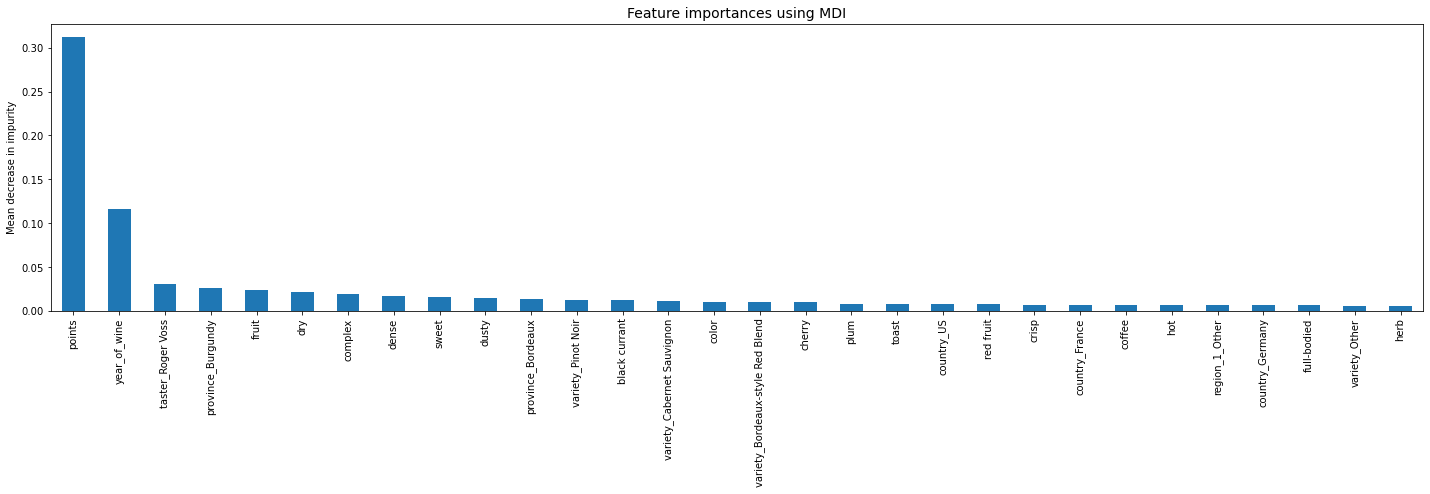

In [141]:
forest_importances = pd.Series(rf1.feature_importances_, index=features_set)
forest_importances_top30 = forest_importances.sort_values(ascending=False).nlargest(n=30)

fig, ax = plt.subplots(figsize = (20,7))
forest_importances_top30.plot.bar(ax=ax)
plt.rcParams['font.size'] = '11'
ax.set_title("Feature importances using MDI", fontsize=14)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This plot gives us insights on the most important predictors for determining wine price, as indicated by the mean decrease in node impurity within the random forest (quality of split at each node). From this we can say that a wine's points rating and vintage (year) are important factors in predicting it's price. Also, specific tastings performed by Roger Voss tend to be on higher priced wines, so we could infer that this particular taster tends to select expensive wines. Similarly, wines produced in the Burgundy region have a tendency to be higher priced. After these predictors, we have an assortment of tasting notes that might be associated with particularly expensive (or inexpensive) wines, such as fruity, dry, complex. and dense.

We will take this information and perform Causal inference on the top predictors.


## 4.3 Final Model Parameter Tuning

#### Methods used are below,
1. Random Forest GridSearchCV : It gave mean test score of around 36 with 6 features 
2. Random Forest RandomizedSearchCV : It gave mean test score of around 37 with 6 features 
3. Gradient Boosting GridSearchCV : It gave best score of around 36 and rest of the parameters can be checked in relevant rows
4. Gradient Boosting RandomizedSearchCV : Best score was 37 and details can be seen in respective cells

Note: Due to infrastructure constraints large scale grid could not be made and we tested on small grids with limited number of features, estimators, bootstrap etc.

### 4.3.1 RF Regressor using GridSearchCV

In [142]:
# We will now obtain the best hyper parameters for these models using GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor(random_state=96)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_ss, y_train)

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=96),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [143]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [144]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=96)

In [145]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

41.71355449102809 {'max_features': 2, 'n_estimators': 3}
37.979580524695834 {'max_features': 2, 'n_estimators': 10}
37.327377353881374 {'max_features': 2, 'n_estimators': 30}
41.370143952158884 {'max_features': 4, 'n_estimators': 3}
37.50457654704328 {'max_features': 4, 'n_estimators': 10}
36.867281780223564 {'max_features': 4, 'n_estimators': 30}
42.52288018291176 {'max_features': 6, 'n_estimators': 3}
37.853486420562334 {'max_features': 6, 'n_estimators': 10}
36.554290142671846 {'max_features': 6, 'n_estimators': 30}
40.42134503166409 {'max_features': 8, 'n_estimators': 3}
37.243106290412726 {'max_features': 8, 'n_estimators': 10}
36.61031991751491 {'max_features': 8, 'n_estimators': 30}
41.465705360159475 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
39.191464579850454 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
42.934095350935586 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
39.74411053233229 {'bootstrap': False, 'max_features': 3, 'n_estim

In [146]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.544585      0.015936         0.032326        0.001792   
1        1.522056      0.034242         0.080238        0.003621   
2        4.380595      0.090354         0.211703        0.007326   
3        0.559149      0.012616         0.030124        0.000999   
4        1.628643      0.021446         0.074092        0.003195   
5        4.623957      0.017802         0.190116        0.005032   
6        0.590148      0.022431         0.028867        0.001147   
7        1.722476      0.020419         0.070314        0.000728   
8        5.019505      0.036835         0.188286        0.002198   
9        0.629809      0.008673         0.029272        0.000973   
10       2.017920      0.059402         0.071937        0.002957   
11       5.942004      0.561863         0.186859        0.006099   
12       0.796301      0.014288         0.034637        0.001307   
13       2.355600      0.031354         0.083459        0.002481   
14       0.786440      0.017022         0.033907        0.002477   
15       2.416827      0.022118         0.081353        0.002830   
16       0.879453      0.018215         0.032294        0.002237   
17       2.612027      0.047207         0.081788        0.002638   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}       -2454.399104   
1             {'max_features': 2, 'n_estimators': 10}       -2208.970298   
2             {'max_features': 2, 'n_estimators': 30}       -2177.093379   
3              {'max_features': 4, 'n_estimators': 3}       -2403.537335   
4             {'max_features': 4, 'n_estimators': 10}       -2187.905206   
5             {'max_features': 4, 'n_estimators': 30}       -2159.659267   
6              {'max_features': 6, 'n_estimators': 3}       -2536.204458   
7             {'max_features': 6, 'n_estimators': 10}       -2213.426722   
8             {'max_features': 6, 'n_estimators': 30}       -2111.807027   
9              {'max_features': 8, 'n_estimators': 3}       -2390.533765   
10            {'max_features': 8, 'n_estimators': 10}       -2118.642162   
11            {'max_features': 8, 'n_estimators': 30}       -2118.687481   
12  {'bootstrap': False, 'max_features': 2, 'n_est...       -2395.331983   
13  {'bootstrap': False, 'max_features': 2, 'n_est...       -2247.244259   
14  {'bootstrap': False, 'max_features': 3, 'n_est...       -2671.148582   
15  {'bootstrap': False, 'max_features': 3, 'n_est...       -2369.203256   
16  {'bootstrap': False, 'max_features': 4, 'n_est...       -2326.922725   
17  {'bootstrap': False, 'max_features': 4, 'n_est...       -2190.445962   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0        -1198.276569  ...     -1740.020628  

### 4.3.2 RF Regressor using RandomizedSearchCV

In [158]:
# We will now obtain the best hyper parameters for these models using RandomizedSearchCV
param_distribs = {
        'n_estimators': randint(low=1, high=25),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=96)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=96)
rnd_search.fit(X_train_ss, y_train)

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\vvaib\anaconda3

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=96),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027E17957790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027E17967AC0>},
                   random_state=96, scoring='neg_mean_squared_error')

In [159]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

38.35470077971509 {'max_features': 5, 'n_estimators': 7}
37.34449068217617 {'max_features': 5, 'n_estimators': 21}
44.64406326190272 {'max_features': 2, 'n_estimators': 2}
37.39953420182712 {'max_features': 3, 'n_estimators': 23}
38.358743332148 {'max_features': 6, 'n_estimators': 7}
41.71355449102809 {'max_features': 2, 'n_estimators': 3}
37.26786787127549 {'max_features': 6, 'n_estimators': 18}
37.32446947395126 {'max_features': 6, 'n_estimators': 19}
37.45389197391774 {'max_features': 4, 'n_estimators': 14}
38.51814433799645 {'max_features': 2, 'n_estimators': 8}


### 4.3.3 Gradient Boosting Regressor using Grid SearchCV

In [114]:
# We will now obtain the best hyper parameters for these models using GridSearchCV / RandomizedSearch
gbc = GradientBoostingRegressor()
parameters = {
    "n_estimators":[5,6,7,8],
    "max_depth":[1],
    "learning_rate":[0.01]
}

In [115]:
cv = GridSearchCV(gbc,parameters,cv=2)
cv.fit(X_train_ss, y_train)

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01], 'max_depth': [1],
                         'n_estimators': [5, 6, 7, 8]})

In [116]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [117]:
display(cv)

Best parameters are: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 8}


0.013 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.016 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 6}
0.018 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 7}
0.021 + or -0.0 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 8}


### 4.3.4 Gradient Boosting Regressor using Randomized SearchCV

In [100]:
model = GradientBoostingRegressor()
parameters = {'learning_rate': sp_randFloat(),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(5, 25),
                  'max_depth'    : sp_randInt(4, 10)
                 }

In [103]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(X_train_ss, y_train)

C:\Users\vvaib\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022F883691C0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022FD6CA71F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022FE0DF8190>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022FD6CA5550>})

In [104]:
print("Results from Random Search " )
print("The best estimator across ALL searched params:", randm.best_estimator_)
print("The best score across ALL searched params:", randm.best_score_)
print("The best parameters across ALL searched params:", randm.best_params_)

Results from Random Search 
The best estimator across ALL searched params: GradientBoostingRegressor(learning_rate=0.2837159789476996, max_depth=5,
                          n_estimators=11, subsample=0.7582964864435131)
The best score across ALL searched params: 0.3529170910426323
The best parameters across ALL searched params: {'learning_rate': 0.2837159789476996, 'max_depth': 5, 'n_estimators': 11, 'subsample': 0.7582964864435131}


# 5. Causal Inference on Selected Features

In [97]:
!pip install causalml # for Google Colab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

     |████████████████████████████████| 401 kB 6.9 MB/s 
     |████████████████████████████████| 326 kB 48.6 MB/s 
     |████████████████████████████████| 1.8 MB 44.9 MB/s 
     |████████████████████████████████| 713 kB 68.2 MB/s 
  Created wheel for causalml: filename=causalml-0.12.1-cp37-cp37m-linux_x86_64.whl size=1036177 sha256=8032c40154514d24eb698d8c45a575e068d6284d75d0c8c12a0473f977da8ce3
  Stored in directory: /root/.cache/pip/wheels/c2/a7/ff/f853b7e4d8d4d9b68df70333a06d6a01fd96fb086e2922ace1
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465084 sha256=2d78982e5396bb36ec4a99c42f72958bebada9361c223e9abae48e82d4f09597
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 5.1 Causal Inference for `points` 

### 5.1.1 Data Preparation

#### 5.1.1.1 Data preprocessing Pipeline

In [98]:
# causal_data = preprocessing_pipeline_ss.fit_transform(X) # with standardization
causal_data = ct.fit_transform(X) # without standardization

# convert to dataframe
causal_data_df = pd.DataFrame(
    causal_data,
    columns = features_set)

causal_data_df.head()

country_Argentina  country_Australia  ...  watery  zingy
0                0.0                0.0  ...     0.0    0.0
1                0.0                0.0  ...     0.0    0.0
2                0.0                0.0  ...     0.0    0.0
3                0.0                0.0  ...     0.0    0.0
4                0.0                0.0  ...     0.0    0.0

[5 rows x 262 columns]

#### 5.1.1.2 Treatment

In [99]:
treatment1 = causal_data_df['points'] # the treatment of causal model
median1 = treatment1.median()
treatment1 = np.array(['treatment: higher points' if x >= median1 else 'control: lower points' for x in treatment1])
treatment1

array(['control: lower points', 'control: lower points',
       'control: lower points', ..., 'treatment: higher points',
       'treatment: higher points', 'treatment: higher points'],
      dtype='<U24')

In [100]:
pd.DataFrame(treatment1).value_counts()

treatment: higher points    66582
control: lower points       44930
dtype: int64

#### 5.1.1.3 Control Features 

In [101]:
X1 = causal_data_df.drop(['points'], axis=1) # drop the column being used as treatment
X1 # Control features of causal model

country_Argentina  country_Australia  ...  watery  zingy
0                     0.0                0.0  ...     0.0    0.0
1                     0.0                0.0  ...     0.0    0.0
2                     0.0                0.0  ...     0.0    0.0
3                     0.0                0.0  ...     0.0    0.0
4                     0.0                0.0  ...     0.0    0.0
...                   ...                ...  ...     ...    ...
111507                0.0                0.0  ...     0.0    0.0
111508                0.0                0.0  ...     0.0    0.0
111509                0.0                0.0  ...     0.0    0.0
111510                0.0                0.0  ...     0.0    0.0
111511                0.0                0.0  ...     0.0    0.0

[111512 rows x 261 columns]

In [102]:
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [103]:
feature_names1 = list(X1.columns) # control feature names of causal model
len(feature_names1)

261

### 5.1.2 Causal ML S-Learner with `LGBMRegressor`

#### 5.1.2.1 Average Treatment Effect (ATE)

In [104]:
treatment1.shape

(111512,)

In [105]:
np.array(y)

array([[15.],
       [14.],
       [13.],
       ...,
       [30.],
       [32.],
       [21.]])

In [106]:
slearner1 = BaseSRegressor(learner=LGBMRegressor(), control_name='control: lower points')
ate_s1 = slearner1.estimate_ate(X=X1, treatment=treatment1, y=np.array(y).flatten())
print('ATE estimate: ', ate_s1[0])

ATE estimate:  17.356111971377562


#### 5.1.2.2 Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [107]:
slearner1 = BaseSRegressor(learner=LGBMRegressor(),control_name='control: lower points')
cate_s1 = slearner1.fit_predict(X=X1, treatment=treatment1, y=np.array(y).flatten())
print('CATE estimate: \n',cate_s1)

CATE estimate: 
 [[15.5901127 ]
 [ 4.02698575]
 [12.43635278]
 ...
 [ 8.8330763 ]
 [ 9.83263663]
 [11.53158411]]


#### 5.1.2.3 Feature Importance for Causal Model

In [108]:
slearner_tau1 = slearner1.fit_predict(X1, treatment1, np.array(y).flatten())
slearner_tau1[:10]

array([[15.5901127 ],
       [ 4.02698575],
       [12.43635278],
       [17.38249473],
       [20.89883012],
       [13.50147784],
       [11.53158411],
       [13.25642137],
       [ 9.95191808],
       [46.10186922]])

In [145]:
importance_dict_s1 = slearner1.get_importance(X=X1, 
                        tau=slearner_tau1, 
                        method='auto', 
                        features=feature_names1, 
                        random_state=666)

In [150]:
# obtain top 10 feature importance
top10_important_s1 = importance_dict_s1['treatment: higher points'][:10]
top10_important_s1

province_Burgundy                   0.276347
year_of_wine                        0.177471
variety_Bordeaux-style Red Blend    0.063390
variety_Cabernet Sauvignon          0.063222
dense                               0.049077
country_US                          0.042059
variety_Pinot Noir                  0.036824
province_Central Italy              0.032096
province_Bordeaux                   0.031017
province_California                 0.027234
dtype: float64

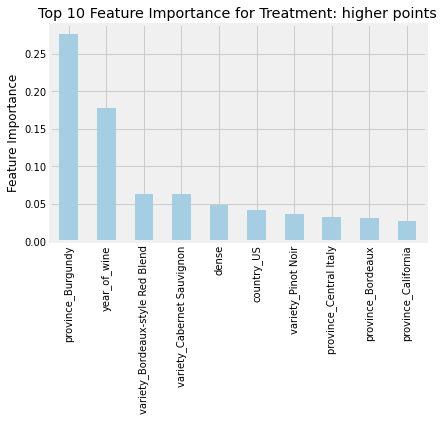

In [172]:
# plot top 10 feature importance
top10_important_s1.plot.bar(title='treatment: higher points', ylabel='Feature Importance')

In [163]:
# slearner1.plot_importance(X=X1, 
#                          tau=slearner_tau1, 
#                          method='auto', 
#                          features=feature_names1, 
#                          random_state=666)

#### 5.1.2.4 Shapley Values

In [111]:
shap_slearner1 = slearner1.get_shap_values(X=X1, tau=slearner_tau1)
shap_slearner1

{'treatment: higher points': array([[ 0.        , -0.02128915,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.0132295 ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.01149196,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.01811517,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.0101742 ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.01543793,  0.        , ...,  0.        ,
          0.        ,  0.        ]])}

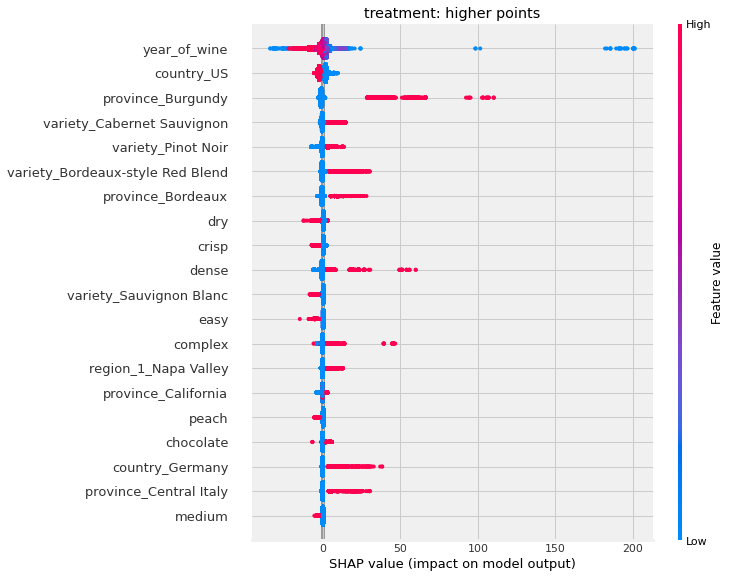

In [112]:
# Plot shap values WITH specifying shap_dict
slearner1.plot_shap_values(X=X1, shap_dict=shap_slearner1, features=feature_names1)

### 5.1.3 Causal ML T-Learner with `XGBTRegressor`

#### 5.1.3.1 Average Treatment Effect (ATE)

In [113]:
# Ready-to-use T-Learner using XGB
tlearner1 = XGBTRegressor(control_name='control: lower points')
ate_t1 = tlearner1.estimate_ate(X=X1, treatment=treatment1, y=np.array(y).flatten())
print('Using the ready-to-use XGBTRegressor class')
print(ate_t1)

[21:17:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([19.0109615]), array([18.63483809]), array([19.38708491]))


#### 5.1.3.2 Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [114]:
tlearner1 = XGBTRegressor(control_name='control: lower points')
cate_t1 = tlearner1.fit_predict(X=X1, treatment=treatment1, y=np.array(y).flatten())
print('CATE estimate: \n',cate_t1)

[21:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CATE estimate: 
 [[21.47551918]
 [10.3713932 ]
 [12.92006683]
 ...
 [13.77482224]
 [14.56138802]
 [17.13865852]]


#### 5.1.3.3 Feature Importance for Causal Model

In [115]:
tlearner_tau1 = tlearner1.fit_predict(X1, treatment1, np.array(y).flatten())
tlearner_tau1

[21:19:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([[21.47551918],
       [10.3713932 ],
       [12.92006683],
       ...,
       [13.77482224],
       [14.56138802],
       [17.13865852]])

In [173]:
importance_dict_t1 = tlearner1.get_importance(X=X1, 
                        tau=tlearner_tau1, 
                        method='auto', 
                        features=feature_names1, 
                        random_state=666)

In [174]:
# obtain top 10 feature importance
top10_important_t1 = importance_dict_t1['treatment: higher points'][:10]
top10_important_t1

province_Burgundy                   0.305554
year_of_wine                        0.171084
variety_Cabernet Sauvignon          0.070597
dense                               0.063534
variety_Bordeaux-style Red Blend    0.060348
country_US                          0.046514
variety_Pinot Noir                  0.038989
country_Portugal                    0.023669
complex                             0.021360
province_Bordeaux                   0.018091
dtype: float64

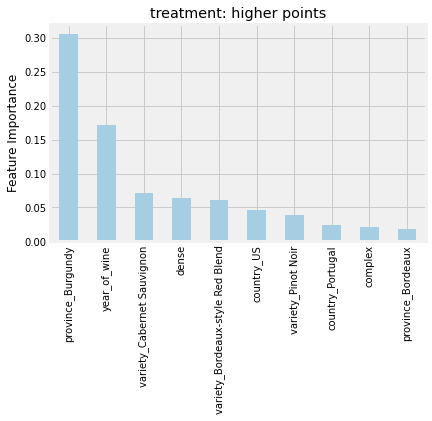

In [175]:
# plot top 10 feature importance
top10_important_t1.plot.bar(title='treatment: higher points', ylabel='Feature Importance')

In [176]:
# tlearner1.plot_importance(X=X1, 
#                          tau=tlearner_tau1, 
#                          method='auto', 
#                          features=feature_names1, 
#                          random_state=666)

#### 5.1.3.4 Shapley Values

In [118]:
shap_tlearner1 = tlearner1.get_shap_values(X=X1, tau=tlearner_tau1)
shap_tlearner1

{'treatment: higher points': array([[-0.00979333, -0.00954449,  0.01130559, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00651624, -0.00855803,  0.00756647, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00790177, -0.00725114,  0.00801576, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00484958, -0.00642903,  0.00863188, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00444046, -0.00642122,  0.00831368, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00940752, -0.00703957,  0.01091847, ...,  0.        ,
          0.        ,  0.        ]])}

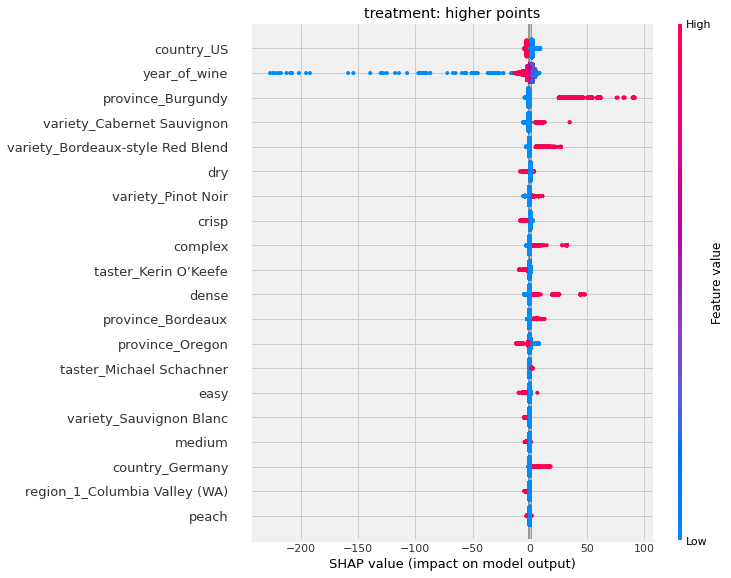

In [119]:
# Plot shap values WITH specifying shap_dict
tlearner1.plot_shap_values(X=X1, shap_dict=shap_tlearner1, features=feature_names1)

## 5.2 Causal Inference for `year_of_wine` 

### 5.2.1 Data Preparation

#### 5.2.1.1 Data preprocessing Pipeline

In [120]:
# causal_data = preprocessing_pipeline_ss.fit_transform(X) # with standardization
causal_data = ct.fit_transform(X) # without standardization

# convert to dataframe
causal_data_df = pd.DataFrame(
    causal_data,
    columns = features_set)

causal_data_df.head()

country_Argentina  country_Australia  ...  watery  zingy
0                0.0                0.0  ...     0.0    0.0
1                0.0                0.0  ...     0.0    0.0
2                0.0                0.0  ...     0.0    0.0
3                0.0                0.0  ...     0.0    0.0
4                0.0                0.0  ...     0.0    0.0

[5 rows x 262 columns]

#### 5.2.1.2 Treatment

In [121]:
treatment2 = causal_data_df['year_of_wine'] # the treatment of causal model
median2 = treatment2.median()
treatment2 = np.array(['treatment: later years' if x >= median2 else 'control: earlier years' for x in treatment2])
treatment2

array(['treatment: later years', 'treatment: later years',
       'treatment: later years', ..., 'treatment: later years',
       'treatment: later years', 'treatment: later years'], dtype='<U22')

In [122]:
pd.DataFrame(treatment2).value_counts()

treatment: later years    62673
control: earlier years    48839
dtype: int64

#### 5.2.1.3 Control Features 

In [123]:
X2 = causal_data_df.drop(['year_of_wine'], axis=1) # drop the column being used as treatment
X2 # Control features of causal model

country_Argentina  country_Australia  ...  watery  zingy
0                     0.0                0.0  ...     0.0    0.0
1                     0.0                0.0  ...     0.0    0.0
2                     0.0                0.0  ...     0.0    0.0
3                     0.0                0.0  ...     0.0    0.0
4                     0.0                0.0  ...     0.0    0.0
...                   ...                ...  ...     ...    ...
111507                0.0                0.0  ...     0.0    0.0
111508                0.0                0.0  ...     0.0    0.0
111509                0.0                0.0  ...     0.0    0.0
111510                0.0                0.0  ...     0.0    0.0
111511                0.0                0.0  ...     0.0    0.0

[111512 rows x 261 columns]

In [124]:
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [125]:
feature_names2 = list(X2.columns) # control feature names of causal model
len(feature_names2)

261

### 5.2.2 Causal ML S-Learner with `LGBMRegressor`

#### 5.2.2.1 Average Treatment Effect (ATE)

In [126]:
slearner2 = BaseSRegressor(learner=LGBMRegressor(), control_name='control: earlier years')
ate_s2 = slearner2.estimate_ate(X=X2, treatment=treatment2, y=np.array(y).flatten())
print('ATE estimate: ', ate_s2[0])

ATE estimate:  -2.8659564599468244


#### 5.2.2.2 Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [127]:
slearner2 = BaseSRegressor(learner=LGBMRegressor(),control_name='control: earlier years')
cate_s2 = slearner2.fit_predict(X=X2, treatment=treatment2, y=np.array(y).flatten())
print('CATE estimate: \n',cate_s2)

CATE estimate: 
 [[-2.27987812e+00]
 [-4.38679978e-03]
 [-1.71316313e+00]
 ...
 [-4.86737425e+00]
 [-3.69966394e+00]
 [-4.86737425e+00]]


#### 5.2.2.3 Feature Importance for Causal Model

In [128]:
slearner_tau2 = slearner2.fit_predict(X2, treatment2, np.array(y).flatten())
slearner_tau2[:10]

array([[-2.27987812e+00],
       [-4.38679978e-03],
       [-1.71316313e+00],
       [-5.78175207e-01],
       [-1.98977502e+00],
       [-5.30106838e+00],
       [-1.87783152e+00],
       [-1.32798068e+01],
       [-1.64679917e+00],
       [ 3.71332979e-01]])

In [181]:
importance_dict_s2 = slearner2.get_importance(X=X2, 
                        tau=slearner_tau2, 
                        method='auto', 
                        features=feature_names2, 
                        random_state=666)

In [182]:
# obtain top 10 feature importance
top10_important_s2 = importance_dict_s2['treatment: later years'][:10]
top10_important_s2

points                        0.456700
country_US                    0.114065
country_Germany               0.111514
province_Burgundy             0.100170
taster_Roger Voss             0.023348
region_1_Toscana              0.022139
variety_Pinot Noir            0.018923
variety_Other                 0.014177
taster_Kerin O’Keefe          0.014150
variety_Cabernet Sauvignon    0.013833
dtype: float64

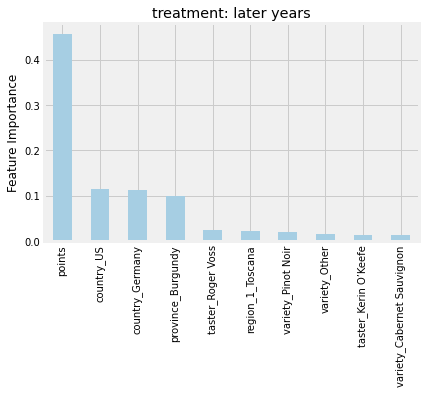

In [183]:
# plot top 10 feature importance
top10_important_s2.plot.bar(title='treatment: later years', ylabel='Feature Importance')

In [184]:
# slearner2.plot_importance(X=X2, 
#                          tau=slearner_tau2, 
#                          method='auto', 
#                          features=feature_names2, 
#                          random_state=666)

#### 5.2.2.4 Shapley Values

In [131]:
shap_slearner2 = slearner2.get_shap_values(X=X2, tau=slearner_tau2)
shap_slearner2

{'treatment: later years': array([[ 0.        ,  0.00293685, -0.00263056, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00235838, -0.00101565, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00301966, -0.00107854, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.00378931, -0.00214743, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00299707, -0.00143293, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00378931, -0.00214743, ...,  0.        ,
          0.        ,  0.        ]])}

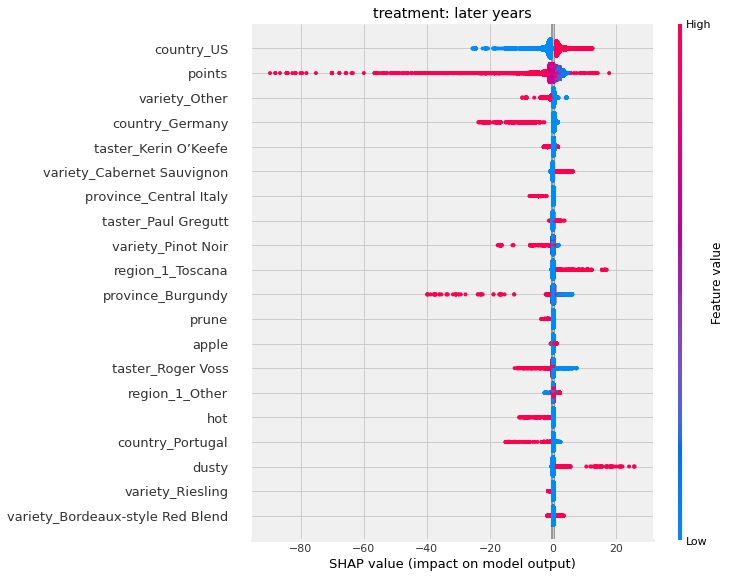

In [132]:
# Plot shap values WITH specifying shap_dict
slearner2.plot_shap_values(X=X2, shap_dict=shap_slearner2, features=feature_names2)

### 5.2.3 Causal ML T-Learner with `XGBTRegressor`

#### 5.2.3.1 Average Treatment Effect (ATE)

In [133]:
# Ready-to-use T-Learner using XGB
tlearner2 = XGBTRegressor(control_name='control: earlier years')
ate_t2 = tlearner2.estimate_ate(X=X2, treatment=treatment2, y=np.array(y).flatten())
print('Using the ready-to-use XGBTRegressor class')
print(ate_t2)

[21:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([-4.22279281]), array([-4.60239515]), array([-3.84319047]))


#### 5.2.3.2 Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [134]:
tlearner2 = XGBTRegressor(control_name='control: earlier years')
cate_t2 = tlearner2.fit_predict(X=X2, treatment=treatment2, y=np.array(y).flatten())
print('CATE estimate: \n',cate_t2)

[21:30:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CATE estimate: 
 [[-3.26694107]
 [ 1.15388298]
 [-0.94130707]
 ...
 [-6.35791206]
 [-1.92648697]
 [-6.50764084]]


#### 5.2.3.3 Feature Importance for Causal Model

In [135]:
tlearner_tau2 = tlearner2.fit_predict(X2, treatment2, np.array(y).flatten())
tlearner_tau2

[21:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([[-3.26694107],
       [ 1.15388298],
       [-0.94130707],
       ...,
       [-6.35791206],
       [-1.92648697],
       [-6.50764084]])

In [185]:
importance_dict_t2 = tlearner2.get_importance(X=X2, 
                        tau=tlearner_tau2, 
                        method='auto', 
                        features=feature_names2, 
                        random_state=666)

In [186]:
# obtain top 10 feature importance
top10_important_t2 = importance_dict_t2['treatment: later years'][:10]
top10_important_t2

points                              0.377732
province_Central Italy              0.135443
country_US                          0.084681
region_1_Toscana                    0.057239
country_Germany                     0.043073
province_Burgundy                   0.042741
variety_Cabernet Sauvignon          0.025122
fruit                               0.022996
variety_Bordeaux-style Red Blend    0.014439
taster_Kerin O’Keefe                0.011108
dtype: float64

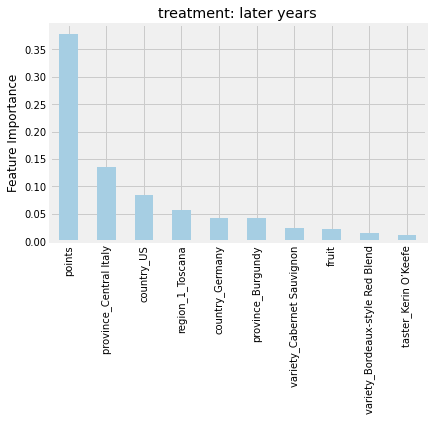

In [187]:
# plot top 10 feature importance
top10_important_t2.plot.bar(title='treatment: later years', ylabel='Feature Importance')

In [188]:
# tlearner2.plot_importance(X=X2, 
#                          tau=tlearner_tau2, 
#                          method='auto', 
#                          features=feature_names2, 
#                          random_state=666)

#### 5.2.3.4 Shapley Values

In [138]:
shap_tlearner2 = tlearner2.get_shap_values(X=X2, tau=tlearner_tau2)
shap_tlearner2

{'treatment: later years': array([[ 0.        , -0.00207851,  0.0027814 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00210647,  0.00254443, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00276463,  0.00256297, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.0017176 ,  0.0027814 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00211285,  0.00276286, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.0017176 ,  0.0027814 , ...,  0.        ,
          0.        ,  0.        ]])}

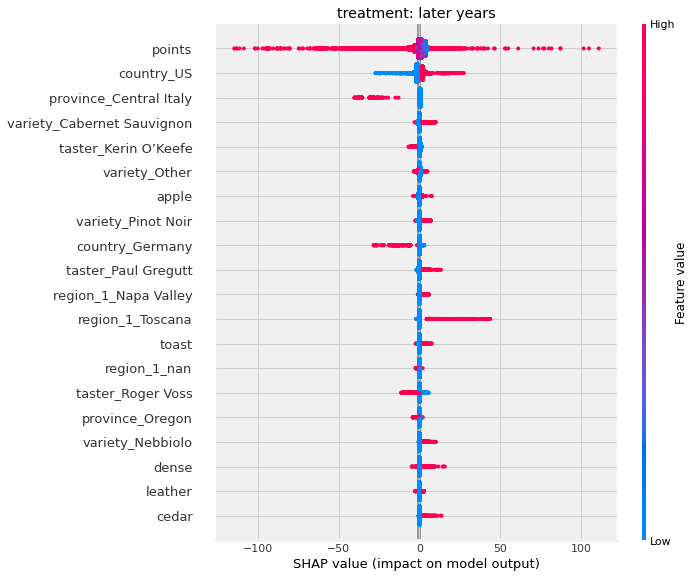

In [139]:
# Plot shap values WITH specifying shap_dict
tlearner2.plot_shap_values(X=X2, shap_dict=shap_tlearner2, features=feature_names2)